<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Load modules and basic settings</b></span><br>
</div>

In [8]:
import sys
sys.path.append('/marconi/home/userexternal/klim0000/my_venv/lib/python3.9/site-packages')
#from skimage.measure import label, regionprops

In [9]:
import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator
import matplotlib.colors as mcolors

from skimage import measure

from scipy.interpolate import RectBivariateSpline


In [10]:
# IEEE journals typically require figures to be very clear at a column width of around 3.5 to 4 inches
fig_width = 3.5  # in inches

plt.rcParams.update({
    # Figure size and DPI
    'figure.figsize': (fig_width, fig_width / 1.618),  # IEEE column width, golden ratio height
    'figure.dpi': 300,                     # Figure resolution
    'savefig.dpi': 300,                    # Save figure resolution
    'savefig.format': 'pdf',               # Preferred format for vector graphics

    # Font settings
    'font.size': 10,                       # Main font size
    'font.family': 'sans-serif',           # Font family
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],  # Font type

    # Axes settings
    'axes.labelsize': 10,                  # Font size of the x and y labels
    'axes.titlesize': 10,                  # Font size of the title
    'axes.linewidth': 1,                   # Edge line width

    # Tick settings
    'xtick.labelsize': 8,                  # Font size of the x tick labels
    'ytick.labelsize': 8,                  # Font size of the y tick labels
    'xtick.major.size': 4,                 # Length of major tick marks
    'xtick.minor.size': 2,                 # Length of minor tick marks
    'xtick.major.width': 1,                # Width of major tick marks
    'xtick.minor.width': 0.5,              # Width of minor tick marks
    'ytick.major.size': 4,                 # Length of major tick marks
    'ytick.minor.size': 2,                 # Length of minor tick marks
    'ytick.major.width': 1,                # Width of major tick marks
    'ytick.minor.width': 0.5,              # Width of minor tick marks

    # Legend settings
    'legend.fontsize': 8,                  # Font size of the legend
    'legend.frameon': True,               # Disable background frame
    'legend.edgecolor':'white',

    # Line settings
    'lines.linewidth': 1.5,                # Line width
    'lines.markersize': 5,                 # Marker size

    # Grid settings
    'grid.alpha': 0.5,                     # Grid line transparency
    'grid.linestyle': ':',                 # Grid line style

})


<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b> Load GBS simulations</b></span><br>
</div>

In [190]:
# Get the current working directory|
cwd = os.getcwd()

#os.chdir('/marconi_work/FUA37_TSVV2/kyungtak/GBS_DN/DN_tria/delta_scan/DNT_dn0p6')

os.chdir('/marconi_work/FUA37_TSVV2/kyungtak/GBS_DN/DN_tria/nu_scan/DNT_nu0p1')
#os.chdir('/marconi_work/FUA37_TSVV2/kyungtak/GBS_DN/DN_tria/nu_scan/DNT_nu1')

# Print the current working directory
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()

Current working directory: /marconi_work/FUA37_TSVV2/kyungtak/GBS_DN/DN_tria/nu_scan/DNT_nu0p01


<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Read the necessary parameters </b></span><br>
<span style="font-size: 16px;">
- to compute, mean ExB, fluctuating ExB, diamagnetic, parallel fluxes<br>
</span>
</div>

In [191]:
t2= s.time[-1]-1
t1= t2-10

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]


dens  = s.get_field('n', z1=z1, z2=z2, t1=t1, t2=t2)
dens_avg  = np.mean(dens, axis=(2,3)); 
dens_avg_tor = np.mean(dens, axis=2)
dens_fluct   = dens[:,:,0,:]-dens_avg_tor

phi   = s.get_field('strmf', z1=z1, z2=z2, t1=t1, t2=t2)
phi_avg   = np.mean(phi, axis=(2,3))
phi_avg_tor = np.mean(phi, axis=2)


theta = s.get_field('theta',     z1=z1, z2=z2, t1=t1, t2=t2)
theta_avg  = np.mean(theta, axis=(2,3))

Te    = s.get_field('Te', z1=z1, z2=z2, t1=t1, t2=t2)
Te_avg    = np.mean(Te, axis=(2,3))


vpare = s.get_field('vpare', z1=z1, z2=z2, t1=t1, t2=t2)
vpare_avg = np.mean(vpare, axis=(2,3))

pe    = dens * Te
pe_avg  = np.mean(pe, axis=(2,3))

phi_diff_all_x = np.gradient(phi, s.dx, axis=1)
phi_diff_all_y = np.gradient(phi, s.dy, axis=0)
phi_avg_diff_x = np.gradient(phi_avg, s.dx, axis=1)
phi_avg_diff_y = np.gradient(phi_avg, s.dy, axis=0)

phi_fluct = phi[:,:,0,:]-phi_avg_tor
phi_fluct_diff_x = np.gradient(phi_fluct, s.dx, axis=1)
phi_fluct_diff_y = np.gradient(phi_fluct, s.dy, axis=0)

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Compute particle fluxes (double-check the expressions) </b></span><br>
</div>

In [192]:
### ExB mean flux
Gamma_mean_ExB_R = bsign * dens_avg * phi_avg_diff_y
Gamma_mean_ExB_Z = -bsign * dens_avg * phi_avg_diff_x

### ExB fluctuating flux
Gamma_fluct_ExB_R = bsign * np.mean(dens_fluct* phi_fluct_diff_y, axis=2)
Gamma_fluct_ExB_Z = -bsign * np.mean(dens_fluct* phi_fluct_diff_x, axis=2)
Gamma_flcut_ExB_tot = Gamma_fluct_ExB_R + Gamma_fluct_ExB_Z

### Parallel flux
[v_par_x, v_par_y]=g.parallel_e_velocity(s, vpare)
vpare_x = np.mean(v_par_x, axis=(2,3))
vpare_y = np.mean(v_par_y, axis=(2,3))
Gamma_par_R = dens_avg * vpare_x
Gamma_par_Z = dens_avg * vpare_y

### Diamagnetic flux
pe_diff_x = np.gradient(pe_avg, s.dx, axis=1)
pe_diff_y = np.gradient(pe_avg, s.dy, axis=0)
Te_diff_x = np.gradient(Te_avg, s.dx, axis=1)
Te_diff_y = np.gradient(Te_avg, s.dy, axis=0)

theta_diff_x = np.gradient(theta_avg, s.dx, axis=1)
theta_diff_y = np.gradient(theta_avg, s.dy, axis=0)

#[v_de_x, v_de_y] = diamagnetic_e_velocity(s, theta_avg, Te_avg)
v_de_x = -bsign * (Te_diff_y + Te_avg * theta_diff_y)
v_de_y = bsign * (Te_diff_x + Te_avg * theta_diff_x)
Gamma_diamag_R = dens_avg * v_de_x
Gamma_diamag_Z = dens_avg * v_de_y


<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Test 2D plot </b></span><br>
</div>

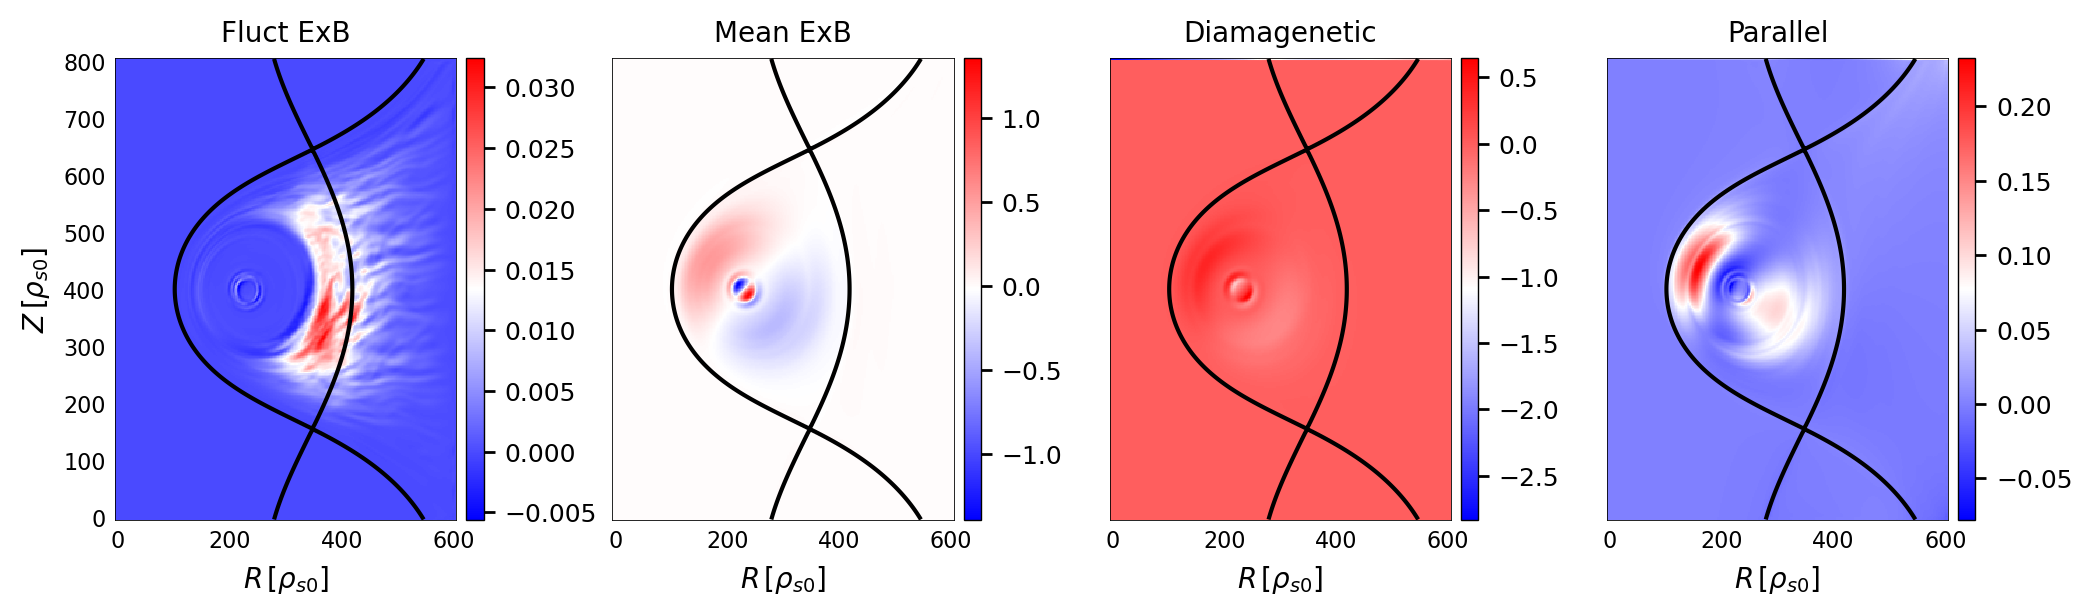

In [193]:
# Assuming definitions for s.x, s.y, s.nx, s.ny, Gamma_fluct_ExB_R, Gamma_fluct_ExB_Z, 
# Gamma_mean_ExB_R, Gamma_mean_ExB_Z, Gamma_diamag_R, Gamma_diamag_Z, Gamma_par_R, Gamma_par_Z, s.Psi, s.iyxpt, and s.ixxpt

# Create the meshgrid
X, Y = np.meshgrid(s.x, s.y)

# Initialize the figure with 1x4 subplots and share the Y-axis across
fig, axes = plt.subplots(1, 4, figsize=(12, 3), dpi=200, sharey=True)

# Data for demonstration, assuming these variables are defined similarly to Gamma_fluct_ExB_R, etc.
gamma_datasets = [(Gamma_fluct_ExB_R + Gamma_fluct_ExB_Z), (Gamma_mean_ExB_R + Gamma_mean_ExB_Z),
                  (Gamma_diamag_R + Gamma_diamag_Z), (Gamma_par_R + Gamma_par_Z)]

for ax, gamma_data in zip(axes, gamma_datasets):
    cs = ax.pcolormesh(X, Y, gamma_data, cmap='bwr')
    
    # Create colorbar for each subplot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(cs, cax=cax)
    cbar.ax.tick_params(labelsize=9)
    cbar.ax.yaxis.get_offset_text().set_fontsize(2)
    cbar.outline.set_linewidth(0.5)
    
    # Add contour lines for specific levels
    ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k')
    
    # Customize the appearance of the plot axes
    ax.set_xlabel(r'$R \,[\rho_{s0}]$')
    if ax == axes[0]:  # Only set the ylabel for the first subplot to avoid repetition
        ax.set_ylabel(r'$Z\, [\rho_{s0}]$', rotation=90)
    ax.grid(True, which='both', alpha=0, linestyle=':')
    
    # Setup minor tick locators for both axes
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    
    # Hide all ticks by setting their length to 0
    ax.tick_params(axis='both', which='both', length=0)
    
    # Adjust the appearance of plot spines
    for spine in ax.spines.values():
        spine.set_linewidth(0.3)

axes[0].set_title('Fluct ExB')
axes[1].set_title('Mean ExB')
axes[2].set_title('Diamagenetic')
axes[3].set_title('Parallel')

#plt.tight_layout()  # Adjust the layout to make room for all subplots and colorbars
plt.show()


<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Set quadrants </b></span><br>
</div>

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Top Right Corner (TRC)</b></span><br>
</div>

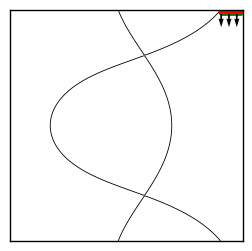

In [226]:
DN_TRC = (548, 798)
coord_TRC, length_TRC = g.get_line(s, DN_TRC, (0, (600-548)), "R", resolution=(0,(600-548)))
# Compute unit normal vector of the surface
dx_TRC = np.gradient(coord_TRC[0,:])
dy_TRC = np.gradient(coord_TRC[1,:])
norm_TRC = np.sqrt(dx_TRC**2 + dy_TRC**2)
normalx_TRC = -dy_TRC/norm_TRC
normaly_TRC = dx_TRC/norm_TRC

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_TRC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_TRC   = Fluct_ExB_R_interp_TRC(coord_TRC[1,:], coord_TRC[0,:], grid=False)
Fluct_ExB_Z_interp_TRC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_TRC   = Fluct_ExB_Z_interp_TRC(coord_TRC[1,:], coord_TRC[0,:], grid=False)

Mean_ExB_R_interp_TRC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_TRC   = Mean_ExB_R_interp_TRC(coord_TRC[1,:], coord_TRC[0,:], grid=False)
Mean_ExB_Z_interp_TRC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_TRC   = Mean_ExB_Z_interp_TRC(coord_TRC[1,:], coord_TRC[0,:], grid=False)

Diamag_R_interp_TRC = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_TRC   = Diamag_R_interp_TRC(coord_TRC[1,:], coord_TRC[0,:], grid=False)
Diamag_Z_interp_TRC = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_TRC   = Diamag_Z_interp_TRC(coord_TRC[1,:], coord_TRC[0,:], grid=False)

Par_R_interp_TRC = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_TRC   = Par_R_interp_TRC(coord_TRC[1,:], coord_TRC[0,:], grid=False)
Par_Z_interp_TRC = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_TRC   = Par_Z_interp_TRC(coord_TRC[1,:], coord_TRC[0,:], grid=False)



# Dot product with the normal vector
Gamma_fluct_ExB_R_TRC_sum = np.dot(Fluct_ExB_R_TRC, -normalx_TRC)
Gamma_fluct_ExB_Z_TRC_sum = np.dot(Fluct_ExB_Z_TRC, -normaly_TRC)
Gamma_fluct_ExB_R_TRC_vec = Fluct_ExB_R_TRC * -normalx_TRC
Gamma_fluct_ExB_Z_TRC_vec = Fluct_ExB_Z_TRC * -normaly_TRC

Gamma_mean_ExB_R_TRC_sum = np.dot(Mean_ExB_R_TRC, -normalx_TRC)
Gamma_mean_ExB_Z_TRC_sum = np.dot(Mean_ExB_Z_TRC, -normaly_TRC)
Gamma_mean_ExB_R_TRC_vec = Mean_ExB_R_TRC * -normalx_TRC
Gamma_mean_ExB_Z_TRC_vec = Mean_ExB_Z_TRC * -normaly_TRC

Gamma_diamag_R_TRC_sum = np.dot(Diamag_R_TRC, -normalx_TRC)
Gamma_diamag_Z_TRC_sum = np.dot(Diamag_Z_TRC, -normaly_TRC)
Gamma_diamag_R_TRC_vec = Diamag_R_TRC * -normalx_TRC
Gamma_diamag_Z_TRC_vec = Diamag_Z_TRC * -normaly_TRC

Gamma_par_R_TRC_sum = np.dot(Par_R_TRC, -normalx_TRC)
Gamma_par_Z_TRC_sum = np.dot(Par_Z_TRC, -normaly_TRC)
Gamma_par_R_TRC_vec = Par_R_TRC * -normalx_TRC
Gamma_par_Z_TRC_vec = Par_Z_TRC * -normaly_TRC

# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_TRC[0], coord_TRC[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_TRC[0,:], coord_TRC[1,:], c='g', s=10)
ax.quiver(coord_TRC[0][::step], coord_TRC[1][::step], -normalx_TRC[::20], -normaly_TRC[::20], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Top Left Corner (TLC)</b></span><br>
</div>

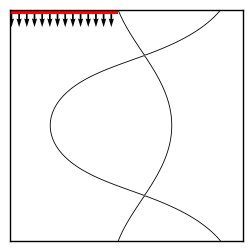

In [227]:
DN_TLC = (274, 798)
coord_TLC, length_TLC = g.get_line(s, DN_TLC, (-274, 0), "R", resolution=(274,0))

# Compute unit normal vector of the surface
dx_TLC = np.gradient(coord_TLC[0,:])
dy_TLC = np.gradient(coord_TLC[1,:])
norm_TLC = np.sqrt(dx_TLC**2 + dy_TLC**2)
normalx_TLC = -dy_TLC/norm_TLC
normaly_TLC = -dx_TLC/norm_TLC

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_TLC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_TLC   = Fluct_ExB_R_interp_TLC(coord_TLC[1,:], coord_TLC[0,:], grid=False)
Fluct_ExB_Z_interp_TLC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_TLC   = Fluct_ExB_Z_interp_TLC(coord_TLC[1,:], coord_TLC[0,:], grid=False)

Mean_ExB_R_interp_TLC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_TLC   = Mean_ExB_R_interp_TLC(coord_TLC[1,:], coord_TLC[0,:], grid=False)
Mean_ExB_Z_interp_TLC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_TLC   = Mean_ExB_Z_interp_TLC(coord_TLC[1,:], coord_TLC[0,:], grid=False)

Diamag_R_interp_TLC = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_TLC   = Diamag_R_interp_TLC(coord_TLC[1,:], coord_TLC[0,:], grid=False)
Diamag_Z_interp_TLC = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_TLC   = Diamag_Z_interp_TLC(coord_TLC[1,:], coord_TLC[0,:], grid=False)

Par_R_interp_TLC = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_TLC   = Par_R_interp_TLC(coord_TLC[1,:], coord_TLC[0,:], grid=False)
Par_Z_interp_TLC = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_TLC   = Par_Z_interp_TLC(coord_TLC[1,:], coord_TLC[0,:], grid=False)



# Dot product with the normal vector
Gamma_fluct_ExB_R_TLC_sum = np.dot(Fluct_ExB_R_TLC, -normalx_TLC)
Gamma_fluct_ExB_Z_TLC_sum = np.dot(Fluct_ExB_Z_TLC, -normaly_TLC)
Gamma_fluct_ExB_R_TLC_vec = Fluct_ExB_R_TLC * -normalx_TLC
Gamma_fluct_ExB_Z_TLC_vec = Fluct_ExB_Z_TLC * -normaly_TLC

Gamma_mean_ExB_R_TLC_sum = np.dot(Mean_ExB_R_TLC, -normalx_TLC)
Gamma_mean_ExB_Z_TLC_sum = np.dot(Mean_ExB_Z_TLC, -normaly_TLC)
Gamma_mean_ExB_R_TLC_vec = Mean_ExB_R_TLC * -normalx_TLC
Gamma_mean_ExB_Z_TLC_vec = Mean_ExB_Z_TLC * -normaly_TLC

Gamma_diamag_R_TLC_sum = np.dot(Diamag_R_TLC, -normalx_TLC)
Gamma_diamag_Z_TLC_sum = np.dot(Diamag_Z_TLC, -normaly_TLC)
Gamma_diamag_R_TLC_vec = Diamag_R_TLC * -normalx_TLC
Gamma_diamag_Z_TLC_vec = Diamag_Z_TLC * -normaly_TLC

Gamma_par_R_TLC_sum = np.dot(Par_R_TLC, -normalx_TLC)
Gamma_par_Z_TLC_sum = np.dot(Par_Z_TLC, -normaly_TLC)
Gamma_par_R_TLC_vec = Par_R_TLC * -normalx_TLC
Gamma_par_Z_TLC_vec = Par_Z_TLC * -normaly_TLC

# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_TLC[0], coord_TLC[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_TLC[0,:], coord_TLC[1,:], c='g', s=1)
ax.quiver(coord_TLC[0][::step], coord_TLC[1][::step], normalx_TLC[::step], normaly_TLC[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Bottom Right Corner (BRC)</b></span><br>
</div>

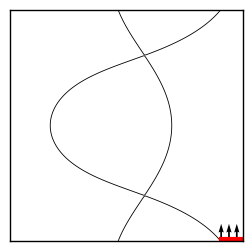

In [228]:
DN_BRC = (548, 2)
coord_BRC, length_BRC = g.get_line(s, DN_BRC, (0, (600-548)), "R", resolution=(0,(600-548)))

# Compute unit normal vector of the surface
dx_BRC = np.gradient(coord_BRC[0,:])
dy_BRC = np.gradient(coord_BRC[1,:])
norm_BRC = np.sqrt(dx_BRC**2 + dy_BRC**2)
normalx_BRC = -dy_BRC/norm_BRC
normaly_BRC = dx_BRC/norm_BRC

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_BRC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_BRC   = Fluct_ExB_R_interp_BRC(coord_BRC[1,:], coord_BRC[0,:], grid=False)
Fluct_ExB_Z_interp_BRC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_BRC   = Fluct_ExB_Z_interp_BRC(coord_BRC[1,:], coord_BRC[0,:], grid=False)

Mean_ExB_R_interp_BRC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_BRC   = Mean_ExB_R_interp_BRC(coord_BRC[1,:], coord_BRC[0,:], grid=False)
Mean_ExB_Z_interp_BRC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_BRC   = Mean_ExB_Z_interp_BRC(coord_BRC[1,:], coord_BRC[0,:], grid=False)

Diamag_R_interp_BRC = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_BRC   = Diamag_R_interp_BRC(coord_BRC[1,:], coord_BRC[0,:], grid=False)
Diamag_Z_interp_BRC = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_BRC   = Diamag_Z_interp_BRC(coord_BRC[1,:], coord_BRC[0,:], grid=False)

Par_R_interp_BRC = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_BRC   = Par_R_interp_BRC(coord_BRC[1,:], coord_BRC[0,:], grid=False)
Par_Z_interp_BRC = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_BRC   = Par_Z_interp_BRC(coord_BRC[1,:], coord_BRC[0,:], grid=False)



# Dot product with the normal vector
Gamma_fluct_ExB_R_BRC_sum = np.dot(Fluct_ExB_R_BRC, -normalx_BRC)
Gamma_fluct_ExB_Z_BRC_sum = np.dot(Fluct_ExB_Z_BRC, -normaly_BRC)
Gamma_fluct_ExB_R_BRC_vec = Fluct_ExB_R_BRC * -normalx_BRC
Gamma_fluct_ExB_Z_BRC_vec = Fluct_ExB_Z_BRC * -normaly_BRC

Gamma_mean_ExB_R_BRC_sum = np.dot(Mean_ExB_R_BRC, -normalx_BRC)
Gamma_mean_ExB_Z_BRC_sum = np.dot(Mean_ExB_Z_BRC, -normaly_BRC)
Gamma_mean_ExB_R_BRC_vec = Mean_ExB_R_BRC * -normalx_BRC
Gamma_mean_ExB_Z_BRC_vec = Mean_ExB_Z_BRC * -normaly_BRC

Gamma_diamag_R_BRC_sum = np.dot(Diamag_R_BRC, -normalx_BRC)
Gamma_diamag_Z_BRC_sum = np.dot(Diamag_Z_BRC, -normaly_BRC)
Gamma_diamag_R_BRC_vec = Diamag_R_BRC * -normalx_BRC
Gamma_diamag_Z_BRC_vec = Diamag_Z_BRC * -normaly_BRC

Gamma_par_R_BRC_sum = np.dot(Par_R_BRC, -normalx_BRC)
Gamma_par_Z_BRC_sum = np.dot(Par_Z_BRC, -normaly_BRC)
Gamma_par_R_BRC_vec = Par_R_BRC * -normalx_BRC
Gamma_par_Z_BRC_vec = Par_Z_BRC * -normaly_BRC

# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_BRC[0], coord_BRC[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_BRC[0,:], coord_BRC[1,:], c='g', s=1)
ax.quiver(coord_BRC[0][::step], coord_BRC[1][::step], normalx_BRC[::step], normaly_BRC[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Bottom Left Corner (BLC)</b></span><br>
</div>

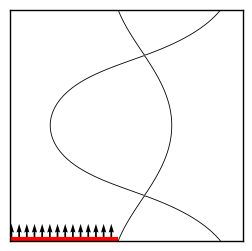

In [229]:
DN_BLC = (274, 2)
coord_BLC, length_BLC = g.get_line(s, DN_BLC, (-274, 0), "R", resolution=(274,0))

# Compute unit normal vector of the surface
dx_BLC = np.gradient(coord_BLC[0,:])
dy_BLC = np.gradient(coord_BLC[1,:])
norm_BLC = np.sqrt(dx_BLC**2 + dy_BLC**2)
normalx_BLC = -dy_BLC/norm_BLC
normaly_BLC = dx_BLC/norm_BLC

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_BLC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_BLC   = Fluct_ExB_R_interp_BLC(coord_BLC[1,:], coord_BLC[0,:], grid=False)
Fluct_ExB_Z_interp_BLC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_BLC   = Fluct_ExB_Z_interp_BLC(coord_BLC[1,:], coord_BLC[0,:], grid=False)

Mean_ExB_R_interp_BLC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_BLC   = Mean_ExB_R_interp_BLC(coord_BLC[1,:], coord_BLC[0,:], grid=False)
Mean_ExB_Z_interp_BLC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_BLC   = Mean_ExB_Z_interp_BLC(coord_BLC[1,:], coord_BLC[0,:], grid=False)

Diamag_R_interp_BLC = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_BLC   = Diamag_R_interp_BLC(coord_BLC[1,:], coord_BLC[0,:], grid=False)
Diamag_Z_interp_BLC = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_BLC   = Diamag_Z_interp_BLC(coord_BLC[1,:], coord_BLC[0,:], grid=False)

Par_R_interp_BLC = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_BLC   = Par_R_interp_BLC(coord_BLC[1,:], coord_BLC[0,:], grid=False)
Par_Z_interp_BLC = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_BLC   = Par_Z_interp_BLC(coord_BLC[1,:], coord_BLC[0,:], grid=False)



# Dot product with the normal vector
Gamma_fluct_ExB_R_BLC_sum = np.dot(Fluct_ExB_R_BLC, -normalx_BLC)
Gamma_fluct_ExB_Z_BLC_sum = np.dot(Fluct_ExB_Z_BLC, -normaly_BLC)
Gamma_fluct_ExB_R_BLC_vec = Fluct_ExB_R_BLC * -normalx_BLC
Gamma_fluct_ExB_Z_BLC_vec = Fluct_ExB_Z_BLC * -normaly_BLC

Gamma_mean_ExB_R_BLC_sum = np.dot(Mean_ExB_R_BLC, -normalx_BLC)
Gamma_mean_ExB_Z_BLC_sum = np.dot(Mean_ExB_Z_BLC, -normaly_BLC)
Gamma_mean_ExB_R_BLC_vec = Mean_ExB_R_BLC * -normalx_BLC
Gamma_mean_ExB_Z_BLC_vec = Mean_ExB_Z_BLC * -normaly_BLC

Gamma_diamag_R_BLC_sum = np.dot(Diamag_R_BLC, -normalx_BLC)
Gamma_diamag_Z_BLC_sum = np.dot(Diamag_Z_BLC, -normaly_BLC)
Gamma_diamag_R_BLC_vec = Diamag_R_BLC * -normalx_BLC
Gamma_diamag_Z_BLC_vec = Diamag_Z_BLC * -normaly_BLC

Gamma_par_R_BLC_sum = np.dot(Par_R_BLC, -normalx_BLC)
Gamma_par_Z_BLC_sum = np.dot(Par_Z_BLC, -normaly_BLC)
Gamma_par_R_BLC_vec = Par_R_BLC * -normalx_BLC
Gamma_par_Z_BLC_vec = Par_Z_BLC * -normaly_BLC

# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_BLC[0], coord_BLC[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_BLC[0,:], coord_BLC[1,:], c='g', s=1)
ax.quiver(coord_BLC[0][::step], coord_BLC[1][::step], normalx_BLC[::step], normaly_BLC[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Right Upper Corner (RUC)</b></span><br>
</div>

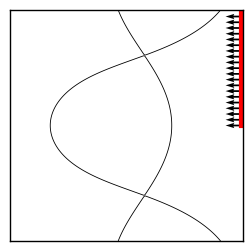

In [230]:
DN_RUC = (600, 400)
coord_RUC, length_RUC = g.get_line(s, DN_RUC, (0, 400), "Z", resolution=(0,400))

# Compute unit normal vector of the surface
dx_RUC = np.gradient(coord_RUC[0,:])
dy_RUC = np.gradient(coord_RUC[1,:])
norm_RUC = np.sqrt(dx_RUC**2 + dy_RUC**2)
normalx_RUC = -dy_RUC/norm_RUC
normaly_RUC = -dx_RUC/norm_RUC

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_RUC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_RUC   = Fluct_ExB_R_interp_RUC(coord_RUC[1,:], coord_RUC[0,:], grid=False)
Fluct_ExB_Z_interp_RUC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_RUC   = Fluct_ExB_Z_interp_RUC(coord_RUC[1,:], coord_RUC[0,:], grid=False)

Mean_ExB_R_interp_RUC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_RUC   = Mean_ExB_R_interp_RUC(coord_RUC[1,:], coord_RUC[0,:], grid=False)
Mean_ExB_Z_interp_RUC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_RUC   = Mean_ExB_Z_interp_RUC(coord_RUC[1,:], coord_RUC[0,:], grid=False)

Diamag_R_interp_RUC = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_RUC   = Diamag_R_interp_RUC(coord_RUC[1,:], coord_RUC[0,:], grid=False)
Diamag_Z_interp_RUC = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_RUC   = Diamag_Z_interp_RUC(coord_RUC[1,:], coord_RUC[0,:], grid=False)

Par_R_interp_RUC = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_RUC   = Par_R_interp_RUC(coord_RUC[1,:], coord_RUC[0,:], grid=False)
Par_Z_interp_RUC = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_RUC   = Par_Z_interp_RUC(coord_RUC[1,:], coord_RUC[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_RUC_sum = np.dot(Fluct_ExB_R_RUC, -normalx_RUC)
Gamma_fluct_ExB_Z_RUC_sum = np.dot(Fluct_ExB_Z_RUC, -normaly_RUC)
Gamma_fluct_ExB_R_RUC_vec = Fluct_ExB_R_RUC * -normalx_RUC
Gamma_fluct_ExB_Z_RUC_vec = Fluct_ExB_Z_RUC * -normaly_RUC

Gamma_mean_ExB_R_RUC_sum = np.dot(Mean_ExB_R_RUC, -normalx_RUC)
Gamma_mean_ExB_Z_RUC_sum = np.dot(Mean_ExB_Z_RUC, -normaly_RUC)
Gamma_mean_ExB_R_RUC_vec = Mean_ExB_R_RUC * -normalx_RUC
Gamma_mean_ExB_Z_RUC_vec = Mean_ExB_Z_RUC * -normaly_RUC

Gamma_diamag_R_RUC_sum = np.dot(Diamag_R_RUC, -normalx_RUC)
Gamma_diamag_Z_RUC_sum = np.dot(Diamag_Z_RUC, -normaly_RUC)
Gamma_diamag_R_RUC_vec = Diamag_R_RUC * -normalx_RUC
Gamma_diamag_Z_RUC_vec = Diamag_Z_RUC * -normaly_RUC

Gamma_par_R_RUC_sum = np.dot(Par_R_RUC, -normalx_RUC)
Gamma_par_Z_RUC_sum = np.dot(Par_Z_RUC, -normaly_RUC)
Gamma_par_R_RUC_vec = Par_R_RUC * -normalx_RUC
Gamma_par_Z_RUC_vec = Par_Z_RUC * -normaly_RUC

# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_RUC[0], coord_RUC[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_RUC[0,:], coord_RUC[1,:], c='g', s=1)
ax.quiver(coord_RUC[0][::step], coord_RUC[1][::step], normalx_RUC[::step], normaly_RUC[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Right Lower Corner (RLC)</b></span><br>
</div>

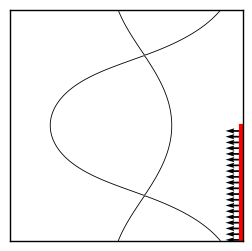

In [199]:
DN_RLC = (600, 400)
coord_RLC, length_RLC = g.get_line(s, DN_RLC, (-400, 0), "Z", resolution=(400,0))

# Compute unit normal vector of the surface
dx_RLC = np.gradient(coord_RLC[0,:])
dy_RLC = np.gradient(coord_RLC[1,:])
norm_RLC = np.sqrt(dx_RLC**2 + dy_RLC**2)
normalx_RLC = -dy_RLC/norm_RLC
normaly_RLC = -dx_RLC/norm_RLC

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_RLC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_RLC   = Fluct_ExB_R_interp_RLC(coord_RLC[1,:], coord_RLC[0,:], grid=False)
Fluct_ExB_Z_interp_RLC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_RLC   = Fluct_ExB_Z_interp_RLC(coord_RLC[1,:], coord_RLC[0,:], grid=False)

Mean_ExB_R_interp_RLC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_RLC   = Mean_ExB_R_interp_RLC(coord_RLC[1,:], coord_RLC[0,:], grid=False)
Mean_ExB_Z_interp_RLC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_RLC   = Mean_ExB_Z_interp_RLC(coord_RLC[1,:], coord_RLC[0,:], grid=False)

Diamag_R_interp_RLC = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_RLC   = Diamag_R_interp_RLC(coord_RLC[1,:], coord_RLC[0,:], grid=False)
Diamag_Z_interp_RLC = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_RLC   = Diamag_Z_interp_RLC(coord_RLC[1,:], coord_RLC[0,:], grid=False)

Par_R_interp_RLC = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_RLC   = Par_R_interp_RLC(coord_RLC[1,:], coord_RLC[0,:], grid=False)
Par_Z_interp_RLC = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_RLC   = Par_Z_interp_RLC(coord_RLC[1,:], coord_RLC[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_RLC_sum = np.dot(Fluct_ExB_R_RLC, -normalx_RLC)
Gamma_fluct_ExB_Z_RLC_sum = np.dot(Fluct_ExB_Z_RLC, -normaly_RLC)
Gamma_fluct_ExB_R_RLC_vec = Fluct_ExB_R_RLC * -normalx_RLC
Gamma_fluct_ExB_Z_RLC_vec = Fluct_ExB_Z_RLC * -normaly_RLC

Gamma_mean_ExB_R_RLC_sum = np.dot(Mean_ExB_R_RLC, -normalx_RLC)
Gamma_mean_ExB_Z_RLC_sum = np.dot(Mean_ExB_Z_RLC, -normaly_RLC)
Gamma_mean_ExB_R_RLC_vec = Mean_ExB_R_RLC * -normalx_RLC
Gamma_mean_ExB_Z_RLC_vec = Mean_ExB_Z_RLC * -normaly_RLC

Gamma_diamag_R_RLC_sum = np.dot(Diamag_R_RLC, -normalx_RLC)
Gamma_diamag_Z_RLC_sum = np.dot(Diamag_Z_RLC, -normaly_RLC)
Gamma_diamag_R_RLC_vec = Diamag_R_RLC * -normalx_RLC
Gamma_diamag_Z_RLC_vec = Diamag_Z_RLC * -normaly_RLC

Gamma_par_R_RLC_sum = np.dot(Par_R_RLC, -normalx_RLC)
Gamma_par_Z_RLC_sum = np.dot(Par_Z_RLC, -normaly_RLC)
Gamma_par_R_RLC_vec = Par_R_RLC * -normalx_RLC
Gamma_par_Z_RLC_vec = Par_Z_RLC * -normaly_RLC

# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_RLC[0], coord_RLC[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_RLC[0,:], coord_RLC[1,:], c='g', s=1)
ax.quiver(coord_RLC[0][::step], coord_RLC[1][::step], normalx_RLC[::step], normaly_RLC[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Left Upper Corner (LUC)</b></span><br>
</div>

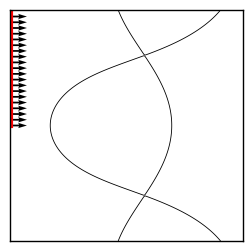

In [200]:
DN_LUC = (0, 400)
coord_LUC, length_LUC = g.get_line(s, DN_LUC, (0, 400), "Z", resolution=(0,400))

# Compute unit normal vector of the surface
dx_LUC = np.gradient(coord_LUC[0,:])
dy_LUC = np.gradient(coord_LUC[1,:])
norm_LUC = np.sqrt(dx_LUC**2 + dy_LUC**2)
normalx_LUC = dy_LUC/norm_LUC
normaly_LUC = -dx_LUC/norm_LUC

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_LUC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_LUC   = Fluct_ExB_R_interp_LUC(coord_LUC[1,:], coord_LUC[0,:], grid=False)
Fluct_ExB_Z_interp_LUC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_LUC   = Fluct_ExB_Z_interp_LUC(coord_LUC[1,:], coord_LUC[0,:], grid=False)

Mean_ExB_R_interp_LUC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_LUC   = Mean_ExB_R_interp_LUC(coord_LUC[1,:], coord_LUC[0,:], grid=False)
Mean_ExB_Z_interp_LUC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_LUC   = Mean_ExB_Z_interp_LUC(coord_LUC[1,:], coord_LUC[0,:], grid=False)

Diamag_R_interp_LUC = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_LUC   = Diamag_R_interp_LUC(coord_LUC[1,:], coord_LUC[0,:], grid=False)
Diamag_Z_interp_LUC = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_LUC   = Diamag_Z_interp_LUC(coord_LUC[1,:], coord_LUC[0,:], grid=False)

Par_R_interp_LUC = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_LUC   = Par_R_interp_LUC(coord_LUC[1,:], coord_LUC[0,:], grid=False)
Par_Z_interp_LUC = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_LUC   = Par_Z_interp_LUC(coord_LUC[1,:], coord_LUC[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_LUC_sum = np.dot(Fluct_ExB_R_LUC, normalx_LUC)
Gamma_fluct_ExB_Z_LUC_sum = np.dot(Fluct_ExB_Z_LUC, normaly_LUC)
Gamma_fluct_ExB_R_LUC_vec = Fluct_ExB_R_LUC * normalx_LUC
Gamma_fluct_ExB_Z_LUC_vec = Fluct_ExB_Z_LUC * normaly_LUC

Gamma_mean_ExB_R_LUC_sum = np.dot(Mean_ExB_R_LUC, normalx_LUC)
Gamma_mean_ExB_Z_LUC_sum = np.dot(Mean_ExB_Z_LUC, normaly_LUC)
Gamma_mean_ExB_R_LUC_vec = Mean_ExB_R_LUC * normalx_LUC
Gamma_mean_ExB_Z_LUC_vec = Mean_ExB_Z_LUC * normaly_LUC

Gamma_diamag_R_LUC_sum = np.dot(Diamag_R_LUC, normalx_LUC)
Gamma_diamag_Z_LUC_sum = np.dot(Diamag_Z_LUC, normaly_LUC)
Gamma_diamag_R_LUC_vec = Diamag_R_LUC * normalx_LUC
Gamma_diamag_Z_LUC_vec = Diamag_Z_LUC * normaly_LUC

Gamma_par_R_LUC_sum = np.dot(Par_R_LUC, normalx_LUC)
Gamma_par_Z_LUC_sum = np.dot(Par_Z_LUC, normaly_LUC)
Gamma_par_R_LUC_vec = Par_R_LUC * normalx_LUC
Gamma_par_Z_LUC_vec = Par_Z_LUC * normaly_LUC

# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_LUC[0], coord_LUC[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_LUC[0,:], coord_LUC[1,:], c='g', s=1)
ax.quiver(coord_LUC[0][::step], coord_LUC[1][::step], normalx_LUC[::step], normaly_LUC[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Left Lower Corner (LLC)</b></span><br>
</div>

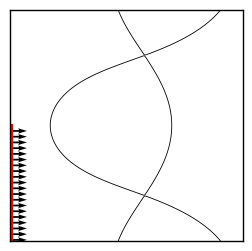

In [201]:
DN_LLC = (0, 400)
coord_LLC, length_LLC = g.get_line(s, DN_LLC, (-400, 0), "Z", resolution=(400,0))

# Compute unit normal vector of the surface
dx_LLC = np.gradient(coord_LLC[0,:])
dy_LLC = np.gradient(coord_LLC[1,:])
norm_LLC = np.sqrt(dx_LLC**2 + dy_LLC**2)
normalx_LLC = dy_LLC/norm_LLC
normaly_LLC = -dx_LLC/norm_LLC

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_LLC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_LLC   = Fluct_ExB_R_interp_LLC(coord_LLC[1,:], coord_LLC[0,:], grid=False)
Fluct_ExB_Z_interp_LLC = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_LLC   = Fluct_ExB_Z_interp_LLC(coord_LLC[1,:], coord_LLC[0,:], grid=False)

Mean_ExB_R_interp_LLC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_LLC   = Mean_ExB_R_interp_LLC(coord_LLC[1,:], coord_LLC[0,:], grid=False)
Mean_ExB_Z_interp_LLC = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_LLC   = Mean_ExB_Z_interp_LLC(coord_LLC[1,:], coord_LLC[0,:], grid=False)

Diamag_R_interp_LLC = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_LLC   = Diamag_R_interp_LLC(coord_LLC[1,:], coord_LLC[0,:], grid=False)
Diamag_Z_interp_LLC = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_LLC   = Diamag_Z_interp_LLC(coord_LLC[1,:], coord_LLC[0,:], grid=False)

Par_R_interp_LLC = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_LLC   = Par_R_interp_LLC(coord_LLC[1,:], coord_LLC[0,:], grid=False)
Par_Z_interp_LLC = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_LLC   = Par_Z_interp_LLC(coord_LLC[1,:], coord_LLC[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_LLC_sum = np.dot(Fluct_ExB_R_LLC, normalx_LLC)
Gamma_fluct_ExB_Z_LLC_sum = np.dot(Fluct_ExB_Z_LLC, normaly_LLC)
Gamma_fluct_ExB_R_LLC_vec = Fluct_ExB_R_LLC * normalx_LLC
Gamma_fluct_ExB_Z_LLC_vec = Fluct_ExB_Z_LLC * normaly_LLC

Gamma_mean_ExB_R_LLC_sum = np.dot(Mean_ExB_R_LLC, normalx_LLC)
Gamma_mean_ExB_Z_LLC_sum = np.dot(Mean_ExB_Z_LLC, normaly_LLC)
Gamma_mean_ExB_R_LLC_vec = Mean_ExB_R_LLC * normalx_LLC
Gamma_mean_ExB_Z_LLC_vec = Mean_ExB_Z_LLC * normaly_LLC

Gamma_diamag_R_LLC_sum = np.dot(Diamag_R_LLC, normalx_LLC)
Gamma_diamag_Z_LLC_sum = np.dot(Diamag_Z_LLC, normaly_LLC)
Gamma_diamag_R_LLC_vec = Diamag_R_LLC * normalx_LLC
Gamma_diamag_Z_LLC_vec = Diamag_Z_LLC * normaly_LLC

Gamma_par_R_LLC_sum = np.dot(Par_R_LLC, normalx_LLC)
Gamma_par_Z_LLC_sum = np.dot(Par_Z_LLC, normaly_LLC)
Gamma_par_R_LLC_vec = Par_R_LLC * normalx_LLC
Gamma_par_Z_LLC_vec = Par_Z_LLC * normaly_LLC

# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_LLC[0], coord_LLC[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_LLC[0,:], coord_LLC[1,:], c='g', s=1)
ax.quiver(coord_LLC[0][::step], coord_LLC[1][::step], normalx_LLC[::step], normaly_LLC[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Upper Outer Mid Plane (UOMP)</b></span><br>
</div>

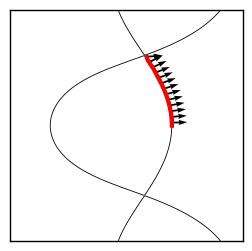

In [202]:
DN_UOMP = (419, 400)
coord_UOMP, length_UOMP = g.get_line(s, DN_UOMP, (-251, 1), "chi", resolution=(251,1))

# Compute unit normal vector of the surface
dx_UOMP = np.gradient(coord_UOMP[0,:])
dy_UOMP = np.gradient(coord_UOMP[1,:])
norm_UOMP = np.sqrt(dx_UOMP**2 + dy_UOMP**2)
normalx_UOMP = -dy_UOMP/norm_UOMP
normaly_UOMP = dx_UOMP/norm_UOMP

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_UOMP = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_UOMP   = Fluct_ExB_R_interp_UOMP(coord_UOMP[1,:], coord_UOMP[0,:], grid=False)
Fluct_ExB_Z_interp_UOMP = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_UOMP   = Fluct_ExB_Z_interp_UOMP(coord_UOMP[1,:], coord_UOMP[0,:], grid=False)

Mean_ExB_R_interp_UOMP = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_UOMP   = Mean_ExB_R_interp_UOMP(coord_UOMP[1,:], coord_UOMP[0,:], grid=False)
Mean_ExB_Z_interp_UOMP = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_UOMP   = Mean_ExB_Z_interp_UOMP(coord_UOMP[1,:], coord_UOMP[0,:], grid=False)

Diamag_R_interp_UOMP = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_UOMP   = Diamag_R_interp_UOMP(coord_UOMP[1,:], coord_UOMP[0,:], grid=False)
Diamag_Z_interp_UOMP = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_UOMP   = Diamag_Z_interp_UOMP(coord_UOMP[1,:], coord_UOMP[0,:], grid=False)

Par_R_interp_UOMP = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_UOMP   = Par_R_interp_UOMP(coord_UOMP[1,:], coord_UOMP[0,:], grid=False)
Par_Z_interp_UOMP = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_UOMP   = Par_Z_interp_UOMP(coord_UOMP[1,:], coord_UOMP[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_UOMP_sum = np.dot(Fluct_ExB_R_UOMP, normalx_UOMP)
Gamma_fluct_ExB_Z_UOMP_sum = np.dot(Fluct_ExB_Z_UOMP, normaly_UOMP)
Gamma_fluct_ExB_R_UOMP_vec = Fluct_ExB_R_UOMP * normalx_UOMP
Gamma_fluct_ExB_Z_UOMP_vec = Fluct_ExB_Z_UOMP * normaly_UOMP

Gamma_mean_ExB_R_UOMP_sum = np.dot(Mean_ExB_R_UOMP, normalx_UOMP)
Gamma_mean_ExB_Z_UOMP_sum = np.dot(Mean_ExB_Z_UOMP, normaly_UOMP)
Gamma_mean_ExB_R_UOMP_vec = Mean_ExB_R_UOMP * normalx_UOMP
Gamma_mean_ExB_Z_UOMP_vec = Mean_ExB_Z_UOMP * normaly_UOMP

Gamma_diamag_R_UOMP_sum = np.dot(Diamag_R_UOMP, normalx_UOMP)
Gamma_diamag_Z_UOMP_sum = np.dot(Diamag_Z_UOMP, normaly_UOMP)
Gamma_diamag_R_UOMP_vec = Diamag_R_UOMP * normalx_UOMP
Gamma_diamag_Z_UOMP_vec = Diamag_Z_UOMP * normaly_UOMP

Gamma_par_R_UOMP_sum = np.dot(Par_R_UOMP, normalx_UOMP)
Gamma_par_Z_UOMP_sum = np.dot(Par_Z_UOMP, normaly_UOMP)
Gamma_par_R_UOMP_vec = Par_R_UOMP * normalx_UOMP
Gamma_par_Z_UOMP_vec = Par_Z_UOMP * normaly_UOMP


# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_UOMP[0], coord_UOMP[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_UOMP[0,:], coord_UOMP[1,:], c='g', s=1)
ax.quiver(coord_UOMP[0][::step], coord_UOMP[1][::step], normalx_UOMP[::step], normaly_UOMP[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Lower Outer Mid Plane (LOMP)</b></span><br>
</div>

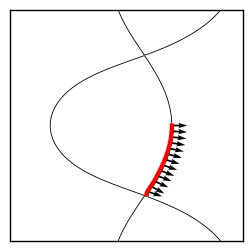

In [203]:
DN_LOMP = (419, 400)
coord_LOMP, length_LOMP = g.get_line(s, DN_LOMP, (1, 251), "chi", resolution=(1,251))

# Compute unit normal vector of the surface
dx_LOMP = np.gradient(coord_LOMP[0,:])
dy_LOMP = np.gradient(coord_LOMP[1,:])
norm_LOMP = np.sqrt(dx_LOMP**2 + dy_LOMP**2)
normalx_LOMP = -dy_LOMP/norm_LOMP
normaly_LOMP = dx_LOMP/norm_LOMP

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_LOMP = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_LOMP   = Fluct_ExB_R_interp_LOMP(coord_LOMP[1,:], coord_LOMP[0,:], grid=False)
Fluct_ExB_Z_interp_LOMP = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_LOMP   = Fluct_ExB_Z_interp_LOMP(coord_LOMP[1,:], coord_LOMP[0,:], grid=False)

Mean_ExB_R_interp_LOMP = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_LOMP   = Mean_ExB_R_interp_LOMP(coord_LOMP[1,:], coord_LOMP[0,:], grid=False)
Mean_ExB_Z_interp_LOMP = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_LOMP   = Mean_ExB_Z_interp_LOMP(coord_LOMP[1,:], coord_LOMP[0,:], grid=False)

Diamag_R_interp_LOMP = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_LOMP   = Diamag_R_interp_LOMP(coord_LOMP[1,:], coord_LOMP[0,:], grid=False)
Diamag_Z_interp_LOMP = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_LOMP   = Diamag_Z_interp_LOMP(coord_LOMP[1,:], coord_LOMP[0,:], grid=False)

Par_R_interp_LOMP = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_LOMP   = Par_R_interp_LOMP(coord_LOMP[1,:], coord_LOMP[0,:], grid=False)
Par_Z_interp_LOMP = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_LOMP   = Par_Z_interp_LOMP(coord_LOMP[1,:], coord_LOMP[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_LOMP_sum = np.dot(Fluct_ExB_R_LOMP, normalx_LOMP)
Gamma_fluct_ExB_Z_LOMP_sum = np.dot(Fluct_ExB_Z_LOMP, normaly_LOMP)
Gamma_fluct_ExB_R_LOMP_vec = Fluct_ExB_R_LOMP * normalx_LOMP
Gamma_fluct_ExB_Z_LOMP_vec = Fluct_ExB_Z_LOMP * normaly_LOMP

Gamma_mean_ExB_R_LOMP_sum = np.dot(Mean_ExB_R_LOMP, normalx_LOMP)
Gamma_mean_ExB_Z_LOMP_sum = np.dot(Mean_ExB_Z_LOMP, normaly_LOMP)
Gamma_mean_ExB_R_LOMP_vec = Mean_ExB_R_LOMP * normalx_LOMP
Gamma_mean_ExB_Z_LOMP_vec = Mean_ExB_Z_LOMP * normaly_LOMP

Gamma_diamag_R_LOMP_sum = np.dot(Diamag_R_LOMP, normalx_LOMP)
Gamma_diamag_Z_LOMP_sum = np.dot(Diamag_Z_LOMP, normaly_LOMP)
Gamma_diamag_R_LOMP_vec = Diamag_R_LOMP * normalx_LOMP
Gamma_diamag_Z_LOMP_vec = Diamag_Z_LOMP * normaly_LOMP

Gamma_par_R_LOMP_sum = np.dot(Par_R_LOMP, normalx_LOMP)
Gamma_par_Z_LOMP_sum = np.dot(Par_Z_LOMP, normaly_LOMP)
Gamma_par_R_LOMP_vec = Par_R_LOMP * normalx_LOMP
Gamma_par_Z_LOMP_vec = Par_Z_LOMP * normaly_LOMP


# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_LOMP[0], coord_LOMP[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_LOMP[0,:], coord_LOMP[1,:], c='g', s=1)
ax.quiver(coord_LOMP[0][::step], coord_LOMP[1][::step], normalx_LOMP[::step], normaly_LOMP[::step], scale=15)


<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Upper Inner Mid Plane (UIMP)</b></span><br>
</div>

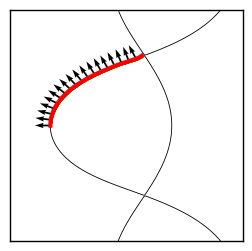

In [204]:
DN_UIMP = (101.7, 400)
coord_UIMP, length_UIMP = g.get_line(s, DN_UIMP, (1, 360), "chi", resolution=(1,360))

# Compute unit normal vector of the surface
dx_UIMP = np.gradient(coord_UIMP[0,:])
dy_UIMP = np.gradient(coord_UIMP[1,:])
norm_UIMP = np.sqrt(dx_UIMP**2 + dy_UIMP**2)
normalx_UIMP = -dy_UIMP/norm_UIMP
normaly_UIMP = dx_UIMP/norm_UIMP

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_UIMP = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_UIMP   = Fluct_ExB_R_interp_UIMP(coord_UIMP[1,:], coord_UIMP[0,:], grid=False)
Fluct_ExB_Z_interp_UIMP = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_UIMP   = Fluct_ExB_Z_interp_UIMP(coord_UIMP[1,:], coord_UIMP[0,:], grid=False)

Mean_ExB_R_interp_UIMP = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_UIMP   = Mean_ExB_R_interp_UIMP(coord_UIMP[1,:], coord_UIMP[0,:], grid=False)
Mean_ExB_Z_interp_UIMP = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_UIMP   = Mean_ExB_Z_interp_UIMP(coord_UIMP[1,:], coord_UIMP[0,:], grid=False)

Diamag_R_interp_UIMP = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_UIMP   = Diamag_R_interp_UIMP(coord_UIMP[1,:], coord_UIMP[0,:], grid=False)
Diamag_Z_interp_UIMP = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_UIMP   = Diamag_Z_interp_UIMP(coord_UIMP[1,:], coord_UIMP[0,:], grid=False)

Par_R_interp_UIMP = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_UIMP   = Par_R_interp_UIMP(coord_UIMP[1,:], coord_UIMP[0,:], grid=False)
Par_Z_interp_UIMP = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_UIMP   = Par_Z_interp_UIMP(coord_UIMP[1,:], coord_UIMP[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_UIMP_sum = np.dot(Fluct_ExB_R_UIMP, normalx_UIMP)
Gamma_fluct_ExB_Z_UIMP_sum = np.dot(Fluct_ExB_Z_UIMP, normaly_UIMP)
Gamma_fluct_ExB_R_UIMP_vec = Fluct_ExB_R_UIMP * normalx_UIMP
Gamma_fluct_ExB_Z_UIMP_vec = Fluct_ExB_Z_UIMP * normaly_UIMP

Gamma_mean_ExB_R_UIMP_sum = np.dot(Mean_ExB_R_UIMP, normalx_UIMP)
Gamma_mean_ExB_Z_UIMP_sum = np.dot(Mean_ExB_Z_UIMP, normaly_UIMP)
Gamma_mean_ExB_R_UIMP_vec = Mean_ExB_R_UIMP * normalx_UIMP
Gamma_mean_ExB_Z_UIMP_vec = Mean_ExB_Z_UIMP * normaly_UIMP

Gamma_diamag_R_UIMP_sum = np.dot(Diamag_R_UIMP, normalx_UIMP)
Gamma_diamag_Z_UIMP_sum = np.dot(Diamag_Z_UIMP, normaly_UIMP)
Gamma_diamag_R_UIMP_vec = Diamag_R_UIMP * normalx_UIMP
Gamma_diamag_Z_UIMP_vec = Diamag_Z_UIMP * normaly_UIMP

Gamma_par_R_UIMP_sum = np.dot(Par_R_UIMP, normalx_UIMP)
Gamma_par_Z_UIMP_sum = np.dot(Par_Z_UIMP, normaly_UIMP)
Gamma_par_R_UIMP_vec = Par_R_UIMP * normalx_UIMP
Gamma_par_Z_UIMP_vec = Par_Z_UIMP * normaly_UIMP


# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_UIMP[0], coord_UIMP[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_UIMP[0,:], coord_UIMP[1,:], c='g', s=1)
ax.quiver(coord_UIMP[0][::step], coord_UIMP[1][::step], normalx_UIMP[::step], normaly_UIMP[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Lower Inner Mid Plane (LIMP)</b></span><br>
</div>

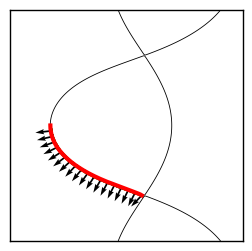

In [205]:
DN_LIMP = (101.7, 400)
coord_LIMP, length_LIMP = g.get_line(s, DN_LIMP, (-360, 1), "chi", resolution=(360,1))

# Compute unit normal vector of the surface
dx_LIMP = np.gradient(coord_LIMP[0,:])
dy_LIMP = np.gradient(coord_LIMP[1,:])
norm_LIMP = np.sqrt(dx_LIMP**2 + dy_LIMP**2)
normalx_LIMP = -dy_LIMP/norm_LIMP
normaly_LIMP = dx_LIMP/norm_LIMP

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_LIMP = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_LIMP   = Fluct_ExB_R_interp_LIMP(coord_LIMP[1,:], coord_LIMP[0,:], grid=False)
Fluct_ExB_Z_interp_LIMP = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_LIMP   = Fluct_ExB_Z_interp_LIMP(coord_LIMP[1,:], coord_LIMP[0,:], grid=False)

Mean_ExB_R_interp_LIMP = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_LIMP   = Mean_ExB_R_interp_LIMP(coord_LIMP[1,:], coord_LIMP[0,:], grid=False)
Mean_ExB_Z_interp_LIMP = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_LIMP   = Mean_ExB_Z_interp_LIMP(coord_LIMP[1,:], coord_LIMP[0,:], grid=False)

Diamag_R_interp_LIMP = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_LIMP   = Diamag_R_interp_LIMP(coord_LIMP[1,:], coord_LIMP[0,:], grid=False)
Diamag_Z_interp_LIMP = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_LIMP   = Diamag_Z_interp_LIMP(coord_LIMP[1,:], coord_LIMP[0,:], grid=False)

Par_R_interp_LIMP = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_LIMP   = Par_R_interp_LIMP(coord_LIMP[1,:], coord_LIMP[0,:], grid=False)
Par_Z_interp_LIMP = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_LIMP   = Par_Z_interp_LIMP(coord_LIMP[1,:], coord_LIMP[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_LIMP_sum = np.dot(Fluct_ExB_R_LIMP, normalx_LIMP)
Gamma_fluct_ExB_Z_LIMP_sum = np.dot(Fluct_ExB_Z_LIMP, normaly_LIMP)
Gamma_fluct_ExB_R_LIMP_vec = Fluct_ExB_R_LIMP * normalx_LIMP
Gamma_fluct_ExB_Z_LIMP_vec = Fluct_ExB_Z_LIMP * normaly_LIMP

Gamma_mean_ExB_R_LIMP_sum = np.dot(Mean_ExB_R_LIMP, normalx_LIMP)
Gamma_mean_ExB_Z_LIMP_sum = np.dot(Mean_ExB_Z_LIMP, normaly_LIMP)
Gamma_mean_ExB_R_LIMP_vec = Mean_ExB_R_LIMP * normalx_LIMP
Gamma_mean_ExB_Z_LIMP_vec = Mean_ExB_Z_LIMP * normaly_LIMP

Gamma_diamag_R_LIMP_sum = np.dot(Diamag_R_LIMP, normalx_LIMP)
Gamma_diamag_Z_LIMP_sum = np.dot(Diamag_Z_LIMP, normaly_LIMP)
Gamma_diamag_R_LIMP_vec = Diamag_R_LIMP * normalx_LIMP
Gamma_diamag_Z_LIMP_vec = Diamag_Z_LIMP * normaly_LIMP

Gamma_par_R_LIMP_sum = np.dot(Par_R_LIMP, normalx_LIMP)
Gamma_par_Z_LIMP_sum = np.dot(Par_Z_LIMP, normaly_LIMP)
Gamma_par_R_LIMP_vec = Par_R_LIMP * normalx_LIMP
Gamma_par_Z_LIMP_vec = Par_Z_LIMP * normaly_LIMP


# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_LIMP[0], coord_LIMP[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_LIMP[0,:], coord_LIMP[1,:], c='g', s=1)
ax.quiver(coord_LIMP[0][::step], coord_LIMP[1][::step], normalx_LIMP[::step], normaly_LIMP[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Right (far) SOL (RSOL)</b></span><br>
</div>

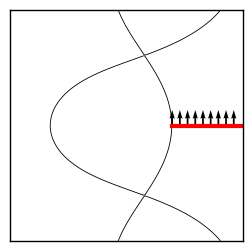

In [206]:
DN_RSOL = (420, 400)
coord_RSOL, length_RSOL = g.get_line(s, DN_RSOL, (0, (600-420)), "R", resolution=(0,(600-420)))

# Compute unit normal vector of the surface
dx_RSOL = np.gradient(coord_RSOL[0,:])
dy_RSOL = np.gradient(coord_RSOL[1,:])
norm_RSOL = np.sqrt(dx_RSOL**2 + dy_RSOL**2)
normalx_RSOL = -dy_RSOL/norm_RSOL
normaly_RSOL = dx_RSOL/norm_RSOL

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_RSOL = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_RSOL   = Fluct_ExB_R_interp_RSOL(coord_RSOL[1,:], coord_RSOL[0,:], grid=False)
Fluct_ExB_Z_interp_RSOL = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_RSOL   = Fluct_ExB_Z_interp_RSOL(coord_RSOL[1,:], coord_RSOL[0,:], grid=False)

Mean_ExB_R_interp_RSOL = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_RSOL   = Mean_ExB_R_interp_RSOL(coord_RSOL[1,:], coord_RSOL[0,:], grid=False)
Mean_ExB_Z_interp_RSOL = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_RSOL   = Mean_ExB_Z_interp_RSOL(coord_RSOL[1,:], coord_RSOL[0,:], grid=False)

Diamag_R_interp_RSOL = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_RSOL   = Diamag_R_interp_RSOL(coord_RSOL[1,:], coord_RSOL[0,:], grid=False)
Diamag_Z_interp_RSOL = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_RSOL   = Diamag_Z_interp_RSOL(coord_RSOL[1,:], coord_RSOL[0,:], grid=False)

Par_R_interp_RSOL = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_RSOL   = Par_R_interp_RSOL(coord_RSOL[1,:], coord_RSOL[0,:], grid=False)
Par_Z_interp_RSOL = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_RSOL   = Par_Z_interp_RSOL(coord_RSOL[1,:], coord_RSOL[0,:], grid=False)



# Dot product with the normal vector
Gamma_fluct_ExB_R_RSOL_sum = np.dot(Fluct_ExB_R_RSOL, normalx_RSOL)
Gamma_fluct_ExB_Z_RSOL_sum = np.dot(Fluct_ExB_Z_RSOL, normaly_RSOL)
Gamma_fluct_ExB_R_RSOL_vec = Fluct_ExB_R_RSOL * normalx_RSOL
Gamma_fluct_ExB_Z_RSOL_vec = Fluct_ExB_Z_RSOL * normaly_RSOL

Gamma_mean_ExB_R_RSOL_sum = np.dot(Mean_ExB_R_RSOL, normalx_RSOL)
Gamma_mean_ExB_Z_RSOL_sum = np.dot(Mean_ExB_Z_RSOL, normaly_RSOL)
Gamma_mean_ExB_R_RSOL_vec = Mean_ExB_R_RSOL * normalx_RSOL
Gamma_mean_ExB_Z_RSOL_vec = Mean_ExB_Z_RSOL * normaly_RSOL

Gamma_diamag_R_RSOL_sum = np.dot(Diamag_R_RSOL, normalx_RSOL)
Gamma_diamag_Z_RSOL_sum = np.dot(Diamag_Z_RSOL, normaly_RSOL)
Gamma_diamag_R_RSOL_vec = Diamag_R_RSOL * normalx_RSOL
Gamma_diamag_Z_RSOL_vec = Diamag_Z_RSOL * normaly_RSOL

Gamma_par_R_RSOL_sum = np.dot(Par_R_RSOL, normalx_RSOL)
Gamma_par_Z_RSOL_sum = np.dot(Par_Z_RSOL, normaly_RSOL)
Gamma_par_R_RSOL_vec = Par_R_RSOL * normalx_RSOL
Gamma_par_Z_RSOL_vec = Par_Z_RSOL * normaly_RSOL

# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_RSOL[0], coord_RSOL[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_RSOL[0,:], coord_RSOL[1,:], c='g', s=1)
ax.quiver(coord_RSOL[0][::step], coord_RSOL[1][::step], normalx_RSOL[::step], normaly_RSOL[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Left (far) SOL (LSOL)</b></span><br>
</div>

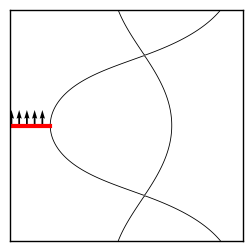

In [207]:
DN_LSOL = (101, 400)
coord_LSOL, length_LSOL = g.get_line(s, DN_LSOL, (-101, 0), "R", resolution=(101,0))

# Compute unit normal vector of the surface
dx_LSOL = np.gradient(coord_LSOL[0,:])
dy_LSOL = np.gradient(coord_LSOL[1,:])
norm_LSOL = np.sqrt(dx_LSOL**2 + dy_LSOL**2)
normalx_LSOL = -dy_LSOL/norm_LSOL
normaly_LSOL = dx_LSOL/norm_LSOL

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_LSOL = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_LSOL   = Fluct_ExB_R_interp_LSOL(coord_LSOL[1,:], coord_LSOL[0,:], grid=False)
Fluct_ExB_Z_interp_LSOL = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_LSOL   = Fluct_ExB_Z_interp_LSOL(coord_LSOL[1,:], coord_LSOL[0,:], grid=False)

Mean_ExB_R_interp_LSOL = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_LSOL   = Mean_ExB_R_interp_LSOL(coord_LSOL[1,:], coord_LSOL[0,:], grid=False)
Mean_ExB_Z_interp_LSOL = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_LSOL   = Mean_ExB_Z_interp_LSOL(coord_LSOL[1,:], coord_LSOL[0,:], grid=False)

Diamag_R_interp_LSOL = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_LSOL   = Diamag_R_interp_LSOL(coord_LSOL[1,:], coord_LSOL[0,:], grid=False)
Diamag_Z_interp_LSOL = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_LSOL   = Diamag_Z_interp_LSOL(coord_LSOL[1,:], coord_LSOL[0,:], grid=False)

Par_R_interp_LSOL = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_LSOL   = Par_R_interp_LSOL(coord_LSOL[1,:], coord_LSOL[0,:], grid=False)
Par_Z_interp_LSOL = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_LSOL   = Par_Z_interp_LSOL(coord_LSOL[1,:], coord_LSOL[0,:], grid=False)



# Dot product with the normal vector
Gamma_fluct_ExB_R_LSOL_sum = np.dot(Fluct_ExB_R_LSOL, normalx_LSOL)
Gamma_fluct_ExB_Z_LSOL_sum = np.dot(Fluct_ExB_Z_LSOL, normaly_LSOL)
Gamma_fluct_ExB_R_LSOL_vec = Fluct_ExB_R_LSOL * normalx_LSOL
Gamma_fluct_ExB_Z_LSOL_vec = Fluct_ExB_Z_LSOL * normaly_LSOL

Gamma_mean_ExB_R_LSOL_sum = np.dot(Mean_ExB_R_LSOL, normalx_LSOL)
Gamma_mean_ExB_Z_LSOL_sum = np.dot(Mean_ExB_Z_LSOL, normaly_LSOL)
Gamma_mean_ExB_R_LSOL_vec = Mean_ExB_R_LSOL * normalx_LSOL
Gamma_mean_ExB_Z_LSOL_vec = Mean_ExB_Z_LSOL * normaly_LSOL

Gamma_diamag_R_LSOL_sum = np.dot(Diamag_R_LSOL, normalx_LSOL)
Gamma_diamag_Z_LSOL_sum = np.dot(Diamag_Z_LSOL, normaly_LSOL)
Gamma_diamag_R_LSOL_vec = Diamag_R_LSOL * normalx_LSOL
Gamma_diamag_Z_LSOL_vec = Diamag_Z_LSOL * normaly_LSOL

Gamma_par_R_LSOL_sum = np.dot(Par_R_LSOL, normalx_LSOL)
Gamma_par_Z_LSOL_sum = np.dot(Par_Z_LSOL, normaly_LSOL)
Gamma_par_R_LSOL_vec = Par_R_LSOL * normalx_LSOL
Gamma_par_Z_LSOL_vec = Par_Z_LSOL * normaly_LSOL

# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_LSOL[0], coord_LSOL[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_LSOL[0,:], coord_LSOL[1,:], c='g', s=1)
ax.quiver(coord_LSOL[0][::step], coord_LSOL[1][::step], normalx_LSOL[::step], normaly_LSOL[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Right Upper X-point (RUX)</b></span><br>
</div>

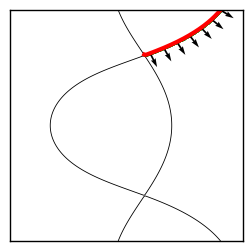

In [208]:
DN_RUX = (347, 648)
coord_RUX, length_RUX = g.get_line(s, DN_RUX, (-258, 1), "chi", resolution=(258,1))

# Compute unit normal vector of the surface
dx_RUX = np.gradient(coord_RUX[0,:])
dy_RUX = np.gradient(coord_RUX[1,:])
norm_RUX = np.sqrt(dx_RUX**2 + dy_RUX**2)
normalx_RUX = -dy_RUX/norm_RUX
normaly_RUX = dx_RUX/norm_RUX

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_RUX = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_RUX   = Fluct_ExB_R_interp_RUX(coord_RUX[1,:], coord_RUX[0,:], grid=False)
Fluct_ExB_Z_interp_RUX = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_RUX   = Fluct_ExB_Z_interp_RUX(coord_RUX[1,:], coord_RUX[0,:], grid=False)

Mean_ExB_R_interp_RUX = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_RUX   = Mean_ExB_R_interp_RUX(coord_RUX[1,:], coord_RUX[0,:], grid=False)
Mean_ExB_Z_interp_RUX = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_RUX   = Mean_ExB_Z_interp_RUX(coord_RUX[1,:], coord_RUX[0,:], grid=False)

Diamag_R_interp_RUX = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_RUX   = Diamag_R_interp_RUX(coord_RUX[1,:], coord_RUX[0,:], grid=False)
Diamag_Z_interp_RUX = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_RUX   = Diamag_Z_interp_RUX(coord_RUX[1,:], coord_RUX[0,:], grid=False)

Par_R_interp_RUX = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_RUX   = Par_R_interp_RUX(coord_RUX[1,:], coord_RUX[0,:], grid=False)
Par_Z_interp_RUX = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_RUX   = Par_Z_interp_RUX(coord_RUX[1,:], coord_RUX[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_RUX_sum = np.dot(Fluct_ExB_R_RUX, normalx_RUX)
Gamma_fluct_ExB_Z_RUX_sum = np.dot(Fluct_ExB_Z_RUX, normaly_RUX)
Gamma_fluct_ExB_R_RUX_vec = Fluct_ExB_R_RUX * normalx_RUX
Gamma_fluct_ExB_Z_RUX_vec = Fluct_ExB_Z_RUX * normaly_RUX

Gamma_mean_ExB_R_RUX_sum = np.dot(Mean_ExB_R_RUX, normalx_RUX)
Gamma_mean_ExB_Z_RUX_sum = np.dot(Mean_ExB_Z_RUX, normaly_RUX)
Gamma_mean_ExB_R_RUX_vec = Mean_ExB_R_RUX * normalx_RUX
Gamma_mean_ExB_Z_RUX_vec = Mean_ExB_Z_RUX * normaly_RUX

Gamma_diamag_R_RUX_sum = np.dot(Diamag_R_RUX, normalx_RUX)
Gamma_diamag_Z_RUX_sum = np.dot(Diamag_Z_RUX, normaly_RUX)
Gamma_diamag_R_RUX_vec = Diamag_R_RUX * normalx_RUX
Gamma_diamag_Z_RUX_vec = Diamag_Z_RUX * normaly_RUX

Gamma_par_R_RUX_sum = np.dot(Par_R_RUX, normalx_RUX)
Gamma_par_Z_RUX_sum = np.dot(Par_Z_RUX, normaly_RUX)
Gamma_par_R_RUX_vec = Par_R_RUX * normalx_RUX
Gamma_par_Z_RUX_vec = Par_Z_RUX * normaly_RUX


# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 40

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_RUX[0], coord_RUX[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_RUX[0,:], coord_RUX[1,:], c='g', s=1)
ax.quiver(coord_RUX[0][::step], coord_RUX[1][::step], normalx_RUX[::step], normaly_RUX[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Left Upper X-point (LUX)</b></span><br>
</div>

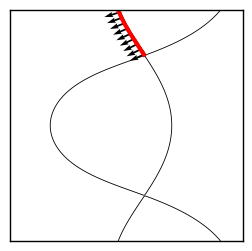

In [209]:
DN_LUX = (346, 648)
coord_LUX, length_LUX = g.get_line(s, DN_LUX, (1, 165), "chi", resolution=(1,165))

# Compute unit normal vector of the surface
dx_LUX = np.gradient(coord_LUX[0,:])
dy_LUX = np.gradient(coord_LUX[1,:])
norm_LUX = np.sqrt(dx_LUX**2 + dy_LUX**2)
normalx_LUX = -dy_LUX/norm_LUX
normaly_LUX = dx_LUX/norm_LUX

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_LUX = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_LUX   = Fluct_ExB_R_interp_LUX(coord_LUX[1,:], coord_LUX[0,:], grid=False)
Fluct_ExB_Z_interp_LUX = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_LUX   = Fluct_ExB_Z_interp_LUX(coord_LUX[1,:], coord_LUX[0,:], grid=False)

Mean_ExB_R_interp_LUX = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_LUX   = Mean_ExB_R_interp_LUX(coord_LUX[1,:], coord_LUX[0,:], grid=False)
Mean_ExB_Z_interp_LUX = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_LUX   = Mean_ExB_Z_interp_LUX(coord_LUX[1,:], coord_LUX[0,:], grid=False)

Diamag_R_interp_LUX = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_LUX   = Diamag_R_interp_LUX(coord_LUX[1,:], coord_LUX[0,:], grid=False)
Diamag_Z_interp_LUX = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_LUX   = Diamag_Z_interp_LUX(coord_LUX[1,:], coord_LUX[0,:], grid=False)

Par_R_interp_LUX = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_LUX   = Par_R_interp_LUX(coord_LUX[1,:], coord_LUX[0,:], grid=False)
Par_Z_interp_LUX = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_LUX   = Par_Z_interp_LUX(coord_LUX[1,:], coord_LUX[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_LUX_sum = np.dot(Fluct_ExB_R_LUX, normalx_LUX)
Gamma_fluct_ExB_Z_LUX_sum = np.dot(Fluct_ExB_Z_LUX, normaly_LUX)
Gamma_fluct_ExB_R_LUX_vec = Fluct_ExB_R_LUX * normalx_LUX
Gamma_fluct_ExB_Z_LUX_vec = Fluct_ExB_Z_LUX * normaly_LUX

Gamma_mean_ExB_R_LUX_sum = np.dot(Mean_ExB_R_LUX, normalx_LUX)
Gamma_mean_ExB_Z_LUX_sum = np.dot(Mean_ExB_Z_LUX, normaly_LUX)
Gamma_mean_ExB_R_LUX_vec = Mean_ExB_R_LUX * normalx_LUX
Gamma_mean_ExB_Z_LUX_vec = Mean_ExB_Z_LUX * normaly_LUX

Gamma_diamag_R_LUX_sum = np.dot(Diamag_R_LUX, normalx_LUX)
Gamma_diamag_Z_LUX_sum = np.dot(Diamag_Z_LUX, normaly_LUX)
Gamma_diamag_R_LUX_vec = Diamag_R_LUX * normalx_LUX
Gamma_diamag_Z_LUX_vec = Diamag_Z_LUX * normaly_LUX

Gamma_par_R_LUX_sum = np.dot(Par_R_LUX, normalx_LUX)
Gamma_par_Z_LUX_sum = np.dot(Par_Z_LUX, normaly_LUX)
Gamma_par_R_LUX_vec = Par_R_LUX * normalx_LUX
Gamma_par_Z_LUX_vec = Par_Z_LUX * normaly_LUX


# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_LUX[0], coord_LUX[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_LUX[0,:], coord_LUX[1,:], c='g', s=1)
ax.quiver(coord_LUX[0][::step], coord_LUX[1][::step], normalx_LUX[::step], normaly_LUX[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Right Lower X-point (RLX)</b></span><br>
</div>

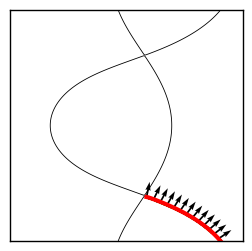

In [210]:
DN_RLX = (353, 150)
coord_RLX, length_RLX = g.get_line(s, DN_RLX, (1, 250), "chi", resolution=(1,250))

# Compute unit normal vector of the surface
dx_RLX = np.gradient(coord_RLX[0,:])
dy_RLX = np.gradient(coord_RLX[1,:])
norm_RLX = np.sqrt(dx_RLX**2 + dy_RLX**2)
normalx_RLX = -dy_RLX/norm_RLX
normaly_RLX = dx_RLX/norm_RLX

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_RLX = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_RLX   = Fluct_ExB_R_interp_RLX(coord_RLX[1,:], coord_RLX[0,:], grid=False)
Fluct_ExB_Z_interp_RLX = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_RLX   = Fluct_ExB_Z_interp_RLX(coord_RLX[1,:], coord_RLX[0,:], grid=False)

Mean_ExB_R_interp_RLX = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_RLX   = Mean_ExB_R_interp_RLX(coord_RLX[1,:], coord_RLX[0,:], grid=False)
Mean_ExB_Z_interp_RLX = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_RLX   = Mean_ExB_Z_interp_RLX(coord_RLX[1,:], coord_RLX[0,:], grid=False)

Diamag_R_interp_RLX = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_RLX   = Diamag_R_interp_RLX(coord_RLX[1,:], coord_RLX[0,:], grid=False)
Diamag_Z_interp_RLX = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_RLX   = Diamag_Z_interp_RLX(coord_RLX[1,:], coord_RLX[0,:], grid=False)

Par_R_interp_RLX = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_RLX   = Par_R_interp_RLX(coord_RLX[1,:], coord_RLX[0,:], grid=False)
Par_Z_interp_RLX = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_RLX   = Par_Z_interp_RLX(coord_RLX[1,:], coord_RLX[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_RLX_sum = np.dot(Fluct_ExB_R_RLX, normalx_RLX)
Gamma_fluct_ExB_Z_RLX_sum = np.dot(Fluct_ExB_Z_RLX, normaly_RLX)
Gamma_fluct_ExB_R_RLX_vec = Fluct_ExB_R_RLX * normalx_RLX
Gamma_fluct_ExB_Z_RLX_vec = Fluct_ExB_Z_RLX * normaly_RLX

Gamma_mean_ExB_R_RLX_sum = np.dot(Mean_ExB_R_RLX, normalx_RLX)
Gamma_mean_ExB_Z_RLX_sum = np.dot(Mean_ExB_Z_RLX, normaly_RLX)
Gamma_mean_ExB_R_RLX_vec = Mean_ExB_R_RLX * normalx_RLX
Gamma_mean_ExB_Z_RLX_vec = Mean_ExB_Z_RLX * normaly_RLX

Gamma_diamag_R_RLX_sum = np.dot(Diamag_R_RLX, normalx_RLX)
Gamma_diamag_Z_RLX_sum = np.dot(Diamag_Z_RLX, normaly_RLX)
Gamma_diamag_R_RLX_vec = Diamag_R_RLX * normalx_RLX
Gamma_diamag_Z_RLX_vec = Diamag_Z_RLX * normaly_RLX

Gamma_par_R_RLX_sum = np.dot(Par_R_RLX, normalx_RLX)
Gamma_par_Z_RLX_sum = np.dot(Par_Z_RLX, normaly_RLX)
Gamma_par_R_RLX_vec = Par_R_RLX * normalx_RLX
Gamma_par_Z_RLX_vec = Par_Z_RLX * normaly_RLX


# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_RLX[0], coord_RLX[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_RLX[0,:], coord_RLX[1,:], c='g', s=1)
ax.quiver(coord_RLX[0][::step], coord_RLX[1][::step], normalx_RLX[::step], normaly_RLX[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Left Lower X-point (LLX)</b></span><br>
</div>

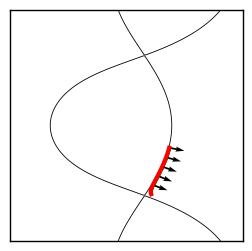

In [211]:
#DN_LLX = (353, 150)
DN_LLX = (365, 160)
coord_LLX, length_LLX = g.get_line(s, DN_LLX, (-170, 1), "chi", resolution=(100,1))

# Compute unit normal vector of the surface
dx_LLX = np.gradient(coord_LLX[0,:])
dy_LLX = np.gradient(coord_LLX[1,:])
norm_LLX = np.sqrt(dx_LLX**2 + dy_LLX**2)
normalx_LLX = -dy_LLX/norm_LLX
normaly_LLX = dx_LLX/norm_LLX

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_LLX = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_LLX   = Fluct_ExB_R_interp_LLX(coord_LLX[1,:], coord_LLX[0,:], grid=False)
Fluct_ExB_Z_interp_LLX = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_LLX   = Fluct_ExB_Z_interp_LLX(coord_LLX[1,:], coord_LLX[0,:], grid=False)

Mean_ExB_R_interp_LLX = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_LLX   = Mean_ExB_R_interp_LLX(coord_LLX[1,:], coord_LLX[0,:], grid=False)
Mean_ExB_Z_interp_LLX = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_LLX   = Mean_ExB_Z_interp_LLX(coord_LLX[1,:], coord_LLX[0,:], grid=False)

Diamag_R_interp_LLX = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_LLX   = Diamag_R_interp_LLX(coord_LLX[1,:], coord_LLX[0,:], grid=False)
Diamag_Z_interp_LLX = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_LLX   = Diamag_Z_interp_LLX(coord_LLX[1,:], coord_LLX[0,:], grid=False)

Par_R_interp_LLX = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_LLX   = Par_R_interp_LLX(coord_LLX[1,:], coord_LLX[0,:], grid=False)
Par_Z_interp_LLX = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_LLX   = Par_Z_interp_LLX(coord_LLX[1,:], coord_LLX[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_LLX_sum = np.dot(Fluct_ExB_R_LLX, normalx_LLX)
Gamma_fluct_ExB_Z_LLX_sum = np.dot(Fluct_ExB_Z_LLX, normaly_LLX)
Gamma_fluct_ExB_R_LLX_vec = Fluct_ExB_R_LLX * normalx_LLX
Gamma_fluct_ExB_Z_LLX_vec = Fluct_ExB_Z_LLX * normaly_LLX

Gamma_mean_ExB_R_LLX_sum = np.dot(Mean_ExB_R_LLX, normalx_LLX)
Gamma_mean_ExB_Z_LLX_sum = np.dot(Mean_ExB_Z_LLX, normaly_LLX)
Gamma_mean_ExB_R_LLX_vec = Mean_ExB_R_LLX * normalx_LLX
Gamma_mean_ExB_Z_LLX_vec = Mean_ExB_Z_LLX * normaly_LLX

Gamma_diamag_R_LLX_sum = np.dot(Diamag_R_LLX, normalx_LLX)
Gamma_diamag_Z_LLX_sum = np.dot(Diamag_Z_LLX, normaly_LLX)
Gamma_diamag_R_LLX_vec = Diamag_R_LLX * normalx_LLX
Gamma_diamag_Z_LLX_vec = Diamag_Z_LLX * normaly_LLX

Gamma_par_R_LLX_sum = np.dot(Par_R_LLX, normalx_LLX)
Gamma_par_Z_LLX_sum = np.dot(Par_Z_LLX, normaly_LLX)
Gamma_par_R_LLX_vec = Par_R_LLX * normalx_LLX
Gamma_par_Z_LLX_vec = Par_Z_LLX * normaly_LLX


# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_LLX[0], coord_LLX[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_LLX[0,:], coord_LLX[1,:], c='g', s=1)
ax.quiver(coord_LLX[0][::step], coord_LLX[1][::step], normalx_LLX[::step], normaly_LLX[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Upper Vertical (UV)</b></span><br>
</div>

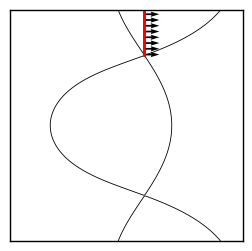

In [212]:
DN_UV = (346, 648)
coord_UV, length_UV = g.get_line(s, DN_UV, (0, 152), "Z", resolution=(0,152))

# Compute unit normal vector of the surface
dx_UV = np.gradient(coord_UV[0,:])
dy_UV = np.gradient(coord_UV[1,:])
norm_UV = np.sqrt(dx_UV**2 + dy_UV**2)
normalx_UV = dy_UV/norm_UV
normaly_UV = dx_UV/norm_UV

# FUV Interpolate to the boundary

Fluct_ExB_R_interp_UV = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_UV   = Fluct_ExB_R_interp_UV(coord_UV[1,:], coord_UV[0,:], grid=False)
Fluct_ExB_Z_interp_UV = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_UV   = Fluct_ExB_Z_interp_UV(coord_UV[1,:], coord_UV[0,:], grid=False)

Mean_ExB_R_interp_UV = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_UV   = Mean_ExB_R_interp_UV(coord_UV[1,:], coord_UV[0,:], grid=False)
Mean_ExB_Z_interp_UV = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_UV   = Mean_ExB_Z_interp_UV(coord_UV[1,:], coord_UV[0,:], grid=False)

Diamag_R_interp_UV = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_UV   = Diamag_R_interp_UV(coord_UV[1,:], coord_UV[0,:], grid=False)
Diamag_Z_interp_UV = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_UV   = Diamag_Z_interp_UV(coord_UV[1,:], coord_UV[0,:], grid=False)

Par_R_interp_UV = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_UV   = Par_R_interp_UV(coord_UV[1,:], coord_UV[0,:], grid=False)
Par_Z_interp_UV = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_UV   = Par_Z_interp_UV(coord_UV[1,:], coord_UV[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_UV_sum = np.dot(Fluct_ExB_R_UV, normalx_UV)
Gamma_fluct_ExB_Z_UV_sum = np.dot(Fluct_ExB_Z_UV, normaly_UV)
Gamma_fluct_ExB_R_UV_vec = Fluct_ExB_R_UV * normalx_UV
Gamma_fluct_ExB_Z_UV_vec = Fluct_ExB_Z_UV * normaly_UV

Gamma_mean_ExB_R_UV_sum = np.dot(Mean_ExB_R_UV, normalx_UV)
Gamma_mean_ExB_Z_UV_sum = np.dot(Mean_ExB_Z_UV, normaly_UV)
Gamma_mean_ExB_R_UV_vec = Mean_ExB_R_UV * normalx_UV
Gamma_mean_ExB_Z_UV_vec = Mean_ExB_Z_UV * normaly_UV

Gamma_diamag_R_UV_sum = np.dot(Diamag_R_UV, normalx_UV)
Gamma_diamag_Z_UV_sum = np.dot(Diamag_Z_UV, normaly_UV)
Gamma_diamag_R_UV_vec = Diamag_R_UV * normalx_UV
Gamma_diamag_Z_UV_vec = Diamag_Z_UV * normaly_UV

Gamma_par_R_UV_sum = np.dot(Par_R_UV, normalx_UV)
Gamma_par_Z_UV_sum = np.dot(Par_Z_UV, normaly_UV)
Gamma_par_R_UV_vec = Par_R_UV * normalx_UV
Gamma_par_Z_UV_vec = Par_Z_UV * normaly_UV


# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_UV[0], coord_UV[1], c='r', lw=2)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_UV[0,:], coord_UV[1,:], c='g', s=0.1)
ax.quiver(coord_UV[0][::step], coord_UV[1][::step], normalx_UV[::step], normaly_UV[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Lower Vertical (LV)</b></span><br>
</div>

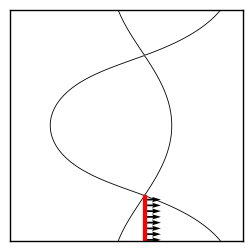

In [213]:
DN_LV = (350, 150)
coord_LV, length_LV = g.get_line(s, DN_LV, (-150, 1), "Z", resolution=(150,1))

# Compute unit normal vector of the surface
dx_LV = np.gradient(coord_LV[0,:])
dy_LV = np.gradient(coord_LV[1,:])
norm_LV = np.sqrt(dx_LV**2 + dy_LV**2)
normalx_LV = dy_LV/norm_LV
normaly_LV = dx_LV/norm_LV

# Flux Interpolate to the boundary

Fluct_ExB_R_interp_LV = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_LV   = Fluct_ExB_R_interp_LV(coord_LV[1,:], coord_LV[0,:], grid=False)
Fluct_ExB_Z_interp_LV = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_LV   = Fluct_ExB_Z_interp_LV(coord_LV[1,:], coord_LV[0,:], grid=False)

Mean_ExB_R_interp_LV = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_LV   = Mean_ExB_R_interp_LV(coord_LV[1,:], coord_LV[0,:], grid=False)
Mean_ExB_Z_interp_LV = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_LV   = Mean_ExB_Z_interp_LV(coord_LV[1,:], coord_LV[0,:], grid=False)

Diamag_R_interp_LV = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_LV   = Diamag_R_interp_LV(coord_LV[1,:], coord_LV[0,:], grid=False)
Diamag_Z_interp_LV = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_LV   = Diamag_Z_interp_LV(coord_LV[1,:], coord_LV[0,:], grid=False)

Par_R_interp_LV = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_LV   = Par_R_interp_LV(coord_LV[1,:], coord_LV[0,:], grid=False)
Par_Z_interp_LV = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_LV   = Par_Z_interp_LV(coord_LV[1,:], coord_LV[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_LV_sum = np.dot(Fluct_ExB_R_LV, normalx_LV)
Gamma_fluct_ExB_Z_LV_sum = np.dot(Fluct_ExB_Z_LV, normaly_LV)
Gamma_fluct_ExB_R_LV_vec = Fluct_ExB_R_LV * normalx_LV
Gamma_fluct_ExB_Z_LV_vec = Fluct_ExB_Z_LV * normaly_LV

Gamma_mean_ExB_R_LV_sum = np.dot(Mean_ExB_R_LV, normalx_LV)
Gamma_mean_ExB_Z_LV_sum = np.dot(Mean_ExB_Z_LV, normaly_LV)
Gamma_mean_ExB_R_LV_vec = Mean_ExB_R_LV * normalx_LV
Gamma_mean_ExB_Z_LV_vec = Mean_ExB_Z_LV * normaly_LV

Gamma_diamag_R_LV_sum = np.dot(Diamag_R_LV, normalx_LV)
Gamma_diamag_Z_LV_sum = np.dot(Diamag_Z_LV, normaly_LV)
Gamma_diamag_R_LV_vec = Diamag_R_LV * normalx_LV
Gamma_diamag_Z_LV_vec = Diamag_Z_LV * normaly_LV

Gamma_par_R_LV_sum = np.dot(Par_R_LV, normalx_LV)
Gamma_par_Z_LV_sum = np.dot(Par_Z_LV, normaly_LV)
Gamma_par_R_LV_vec = Par_R_LV * normalx_LV
Gamma_par_Z_LV_vec = Par_Z_LV * normaly_LV


# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_LV[0], coord_LV[1], c='r', lw=3)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_LV[0,:], coord_LV[1,:], c='g', s=1)
ax.quiver(coord_LV[0][::step], coord_LV[1][::step], normalx_LV[::step], normaly_LV[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Top Wall (TW)</b></span><br>
</div>

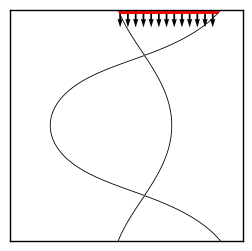

In [214]:
DN_TW = (346, 797)
coord_TW, length_TW = g.get_line(s, DN_TW, (-62, 192), "R", resolution=(62,192))

# Compute unit normal vector of the surface
dx_TW = np.gradient(coord_TW[0,:])
dy_TW = np.gradient(coord_TW[1,:])
norm_TW = np.sqrt(dx_TW**2 + dy_TW**2)
normalx_TW = dy_TW/norm_TW
normaly_TW = -dx_TW/norm_TW

# FTW Interpolate to the boundary

Fluct_ExB_R_interp_TW = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_TW   = Fluct_ExB_R_interp_TW(coord_TW[1,:], coord_TW[0,:], grid=False)
Fluct_ExB_Z_interp_TW = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_TW   = Fluct_ExB_Z_interp_TW(coord_TW[1,:], coord_TW[0,:], grid=False)

Mean_ExB_R_interp_TW = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_TW   = Mean_ExB_R_interp_TW(coord_TW[1,:], coord_TW[0,:], grid=False)
Mean_ExB_Z_interp_TW = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_TW   = Mean_ExB_Z_interp_TW(coord_TW[1,:], coord_TW[0,:], grid=False)

Diamag_R_interp_TW = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_TW   = Diamag_R_interp_TW(coord_TW[1,:], coord_TW[0,:], grid=False)
Diamag_Z_interp_TW = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_TW   = Diamag_Z_interp_TW(coord_TW[1,:], coord_TW[0,:], grid=False)

Par_R_interp_TW = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_TW   = Par_R_interp_TW(coord_TW[1,:], coord_TW[0,:], grid=False)
Par_Z_interp_TW = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_TW   = Par_Z_interp_TW(coord_TW[1,:], coord_TW[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_TW_sum = np.dot(Fluct_ExB_R_TW, normalx_TW)
Gamma_fluct_ExB_Z_TW_sum = np.dot(Fluct_ExB_Z_TW, normaly_TW)
Gamma_fluct_ExB_R_TW_vec = Fluct_ExB_R_TW * normalx_TW
Gamma_fluct_ExB_Z_TW_vec = Fluct_ExB_Z_TW * normaly_TW

Gamma_mean_ExB_R_TW_sum = np.dot(Mean_ExB_R_TW, normalx_TW)
Gamma_mean_ExB_Z_TW_sum = np.dot(Mean_ExB_Z_TW, normaly_TW)
Gamma_mean_ExB_R_TW_vec = Mean_ExB_R_TW * normalx_TW
Gamma_mean_ExB_Z_TW_vec = Mean_ExB_Z_TW * normaly_TW

Gamma_diamag_R_TW_sum = np.dot(Diamag_R_TW, normalx_TW)
Gamma_diamag_Z_TW_sum = np.dot(Diamag_Z_TW, normaly_TW)
Gamma_diamag_R_TW_vec = Diamag_R_TW * normalx_TW
Gamma_diamag_Z_TW_vec = Diamag_Z_TW * normaly_TW

Gamma_par_R_TW_sum = np.dot(Par_R_TW, normalx_TW)
Gamma_par_Z_TW_sum = np.dot(Par_Z_TW, normaly_TW)
Gamma_par_R_TW_vec = Par_R_TW * normalx_TW
Gamma_par_Z_TW_vec = Par_Z_TW * normaly_TW


# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_TW[0], coord_TW[1], c='r', lw=2)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_TW[0,:], coord_TW[1,:], c='g', s=0.1)
ax.quiver(coord_TW[0][::step], coord_TW[1][::step], normalx_TW[::step], normaly_TW[::step], scale=15)

<div class="alert alert-block alert-info">
<span style="font-size: 16px;"><b> Bottom Wall (BW)</b></span><br>
</div>

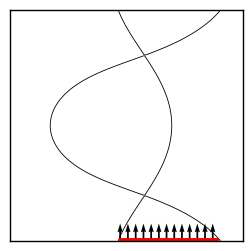

In [215]:
DN_BW = (346, 3)
coord_BW, length_BW = g.get_line(s, DN_BW, (-62, 192), "R", resolution=(62,192))

# Compute unit normal vector of the surface
dx_BW = np.gradient(coord_BW[0,:])
dy_BW = np.gradient(coord_BW[1,:])
norm_BW = np.sqrt(dx_BW**2 + dy_BW**2)
normalx_BW = dy_BW/norm_BW
normaly_BW = dx_BW/norm_BW

# FBW Interpolate to the boundary

Fluct_ExB_R_interp_BW = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_R)
Fluct_ExB_R_BW   = Fluct_ExB_R_interp_BW(coord_BW[1,:], coord_BW[0,:], grid=False)
Fluct_ExB_Z_interp_BW = RectBivariateSpline(s.y, s.x, Gamma_fluct_ExB_Z)
Fluct_ExB_Z_BW   = Fluct_ExB_Z_interp_BW(coord_BW[1,:], coord_BW[0,:], grid=False)

Mean_ExB_R_interp_BW = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_R)
Mean_ExB_R_BW   = Mean_ExB_R_interp_BW(coord_BW[1,:], coord_BW[0,:], grid=False)
Mean_ExB_Z_interp_BW = RectBivariateSpline(s.y, s.x, Gamma_mean_ExB_Z)
Mean_ExB_Z_BW   = Mean_ExB_Z_interp_BW(coord_BW[1,:], coord_BW[0,:], grid=False)

Diamag_R_interp_BW = RectBivariateSpline(s.y, s.x, Gamma_diamag_R)
Diamag_R_BW   = Diamag_R_interp_BW(coord_BW[1,:], coord_BW[0,:], grid=False)
Diamag_Z_interp_BW = RectBivariateSpline(s.y, s.x, Gamma_diamag_Z)
Diamag_Z_BW   = Diamag_Z_interp_BW(coord_BW[1,:], coord_BW[0,:], grid=False)

Par_R_interp_BW = RectBivariateSpline(s.y, s.x, Gamma_par_R)
Par_R_BW   = Par_R_interp_BW(coord_BW[1,:], coord_BW[0,:], grid=False)
Par_Z_interp_BW = RectBivariateSpline(s.y, s.x, Gamma_par_Z)
Par_Z_BW   = Par_Z_interp_BW(coord_BW[1,:], coord_BW[0,:], grid=False)

# Dot product with the normal vector
Gamma_fluct_ExB_R_BW_sum = np.dot(Fluct_ExB_R_BW, normalx_BW)
Gamma_fluct_ExB_Z_BW_sum = np.dot(Fluct_ExB_Z_BW, normaly_BW)
Gamma_fluct_ExB_R_BW_vec = Fluct_ExB_R_BW * normalx_BW
Gamma_fluct_ExB_Z_BW_vec = Fluct_ExB_Z_BW * normaly_BW

Gamma_mean_ExB_R_BW_sum = np.dot(Mean_ExB_R_BW, normalx_BW)
Gamma_mean_ExB_Z_BW_sum = np.dot(Mean_ExB_Z_BW, normaly_BW)
Gamma_mean_ExB_R_BW_vec = Mean_ExB_R_BW * normalx_BW
Gamma_mean_ExB_Z_BW_vec = Mean_ExB_Z_BW * normaly_BW

Gamma_diamag_R_BW_sum = np.dot(Diamag_R_BW, normalx_BW)
Gamma_diamag_Z_BW_sum = np.dot(Diamag_Z_BW, normaly_BW)
Gamma_diamag_R_BW_vec = Diamag_R_BW * normalx_BW
Gamma_diamag_Z_BW_vec = Diamag_Z_BW * normaly_BW

Gamma_par_R_BW_sum = np.dot(Par_R_BW, normalx_BW)
Gamma_par_Z_BW_sum = np.dot(Par_Z_BW, normaly_BW)
Gamma_par_R_BW_vec = Par_R_BW * normalx_BW
Gamma_par_Z_BW_vec = Par_Z_BW * normaly_BW


# Check if the boundary is correct
X, Y = np.meshgrid(s.x, s.y)

step = 20

fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]], colors='k', linewidths=0.6)
ax.plot(coord_BW[0], coord_BW[1], c='r', lw=2)
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
ax.scatter(coord_BW[0,:], coord_BW[1,:], c='g', s=0.1)
ax.quiver(coord_BW[0][::step], coord_BW[1][::step], normalx_BW[::step], normaly_BW[::step], scale=15)

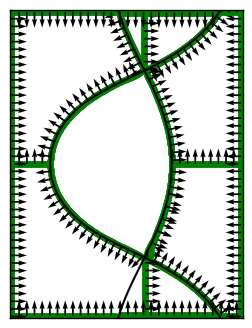

In [216]:
# All flux
X, Y = np.meshgrid(s.x, s.y)
fig, ax = plt.subplots(figsize=(3,4), dpi=100)
Z = np.random.rand(s.nx,s.ny)

step=20
# Separatrix
ax.scatter(coord_UOMP[0,:], coord_UOMP[1,:], c='g', s=10)
ax.quiver(coord_UOMP[0][::step], coord_UOMP[1][::step], normalx_UOMP[::step], normaly_UOMP[::step], scale=15)
ax.scatter(coord_LOMP[0,:], coord_LOMP[1,:], c='g', s=10)
ax.quiver(coord_LOMP[0][::step], coord_LOMP[1][::step], normalx_LOMP[::20], normaly_LOMP[::20], scale=15)
ax.scatter(coord_UIMP[0,:], coord_UIMP[1,:], c='g', s=10)
ax.quiver(coord_UIMP[0][::step], coord_UIMP[1][::step], normalx_UIMP[::20], normaly_UIMP[::20], scale=15)
ax.scatter(coord_LIMP[0,:], coord_LIMP[1,:], c='g', s=10)
ax.quiver(coord_LIMP[0][::step], coord_LIMP[1][::step], normalx_LIMP[::20], normaly_LIMP[::20], scale=15)
ax.scatter(coord_RUX[0,:], coord_RUX[1,:], c='g', s=10)
ax.quiver(coord_RUX[0][::step], coord_RUX[1][::step], normalx_RUX[::20], normaly_RUX[::20], scale=15)
ax.scatter(coord_LUX[0,:], coord_LUX[1,:], c='g', s=10)
ax.quiver(coord_LUX[0][::step], coord_LUX[1][::step], normalx_LUX[::20], normaly_LUX[::20], scale=15)
ax.scatter(coord_RLX[0,:], coord_RLX[1,:], c='g', s=10)
ax.quiver(coord_RLX[0][::step], coord_RLX[1][::step], normalx_RLX[::20], normaly_RLX[::20], scale=15)
ax.scatter(coord_LLX[0,:], coord_LLX[1,:], c='g', s=10)
ax.quiver(coord_LLX[0][::step], coord_LLX[1][::step], normalx_LLX[::20], normaly_LLX[::20], scale=15)
ax.scatter(coord_RSOL[0,:], coord_RSOL[1,:], c='g', s=10)
ax.quiver(coord_RSOL[0][::step], coord_RSOL[1][::step], normalx_RSOL[::20], normaly_RSOL[::20], scale=15)
ax.scatter(coord_LSOL[0,:], coord_LSOL[1,:], c='g', s=10)
ax.quiver(coord_LSOL[0][::step], coord_LSOL[1][::step], normalx_LSOL[::20], normaly_LSOL[::20], scale=15)

# Wall regions
ax.scatter(coord_TRC[0,:], coord_TRC[1,:], c='g', s=10)
ax.quiver(coord_TRC[0][::step], coord_TRC[1][::step], normalx_TRC[::20], normaly_TRC[::20], scale=15)
ax.scatter(coord_TLC[0,:], coord_TLC[1,:], c='g', s=10)
ax.quiver(coord_TLC[0][::step], coord_TLC[1][::step], normalx_TLC[::20], normaly_TLC[::20], scale=15)
ax.scatter(coord_BRC[0,:], coord_BRC[1,:], c='g', s=10)
ax.quiver(coord_BRC[0][::step], coord_BRC[1][::step], normalx_BRC[::20], normaly_BRC[::20], scale=15)
ax.scatter(coord_BLC[0,:], coord_BLC[1,:], c='g', s=10)
ax.quiver(coord_BLC[0][::step], coord_BLC[1][::step], normalx_BLC[::20], normaly_BLC[::20], scale=15)
ax.scatter(coord_RUC[0,:], coord_RUC[1,:], c='g', s=10)
ax.quiver(coord_RUC[0][::step], coord_RUC[1][::step], normalx_RUC[::20], normaly_RUC[::20], scale=15)
ax.scatter(coord_RLC[0,:], coord_RLC[1,:], c='g', s=10)
ax.quiver(coord_RLC[0][::step], coord_RLC[1][::step], normalx_RLC[::20], normaly_RLC[::20], scale=15)
ax.scatter(coord_LUC[0,:], coord_LUC[1,:], c='g', s=10)
ax.quiver(coord_LUC[0][::step], coord_LUC[1][::step], normalx_LUC[::20], normaly_LUC[::20], scale=15)
ax.scatter(coord_LLC[0,:], coord_LLC[1,:], c='g', s=10)
ax.quiver(coord_LLC[0][::step], coord_LLC[1][::step], normalx_LLC[::20], normaly_LLC[::20], scale=15)

# Vertical in PFR
ax.scatter(coord_UV[0,:], coord_UV[1,:], c='g', s=10)
ax.quiver(coord_UV[0][::step], coord_UV[1][::step], normalx_UV[::20], normaly_UV[::20], scale=15)
ax.scatter(coord_LV[0,:], coord_LV[1,:], c='g', s=10)
ax.quiver(coord_LV[0][::step], coord_LV[1][::step], normalx_LV[::20], normaly_LV[::20], scale=15)
ax.scatter(coord_TW[0,:], coord_TW[1,:], c='g', s=10)
ax.quiver(coord_TW[0][::step], coord_TW[1][::step], normalx_TW[::20], normaly_TW[::20], scale=15)
ax.scatter(coord_BW[0,:], coord_BW[1,:], c='g', s=10)
ax.quiver(coord_BW[0][::step], coord_BW[1][::step], normalx_BW[::20], normaly_BW[::20], scale=15)

# Separatrix
ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='k')
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)


<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Flux measurements </b></span><br>
</div>

In [217]:
# Data for demonstration, assuming these variables are defined similarly to Gamma_fluct_ExB_R, etc.
#gamma_datasets = [(Gamma_fluct_ExB_R + Gamma_fluct_ExB_Z), (Gamma_mean_ExB_R + Gamma_mean_ExB_Z),
#                  (Gamma_diamag_R + Gamma_diamag_Z), (Gamma_par_R + Gamma_par_Z)]

Gamma_fluct_ExB_R_BW_sum = np.dot(Fluct_ExB_R_BW, normalx_BW)
Gamma_fluct_ExB_Z_BW_sum = np.dot(Fluct_ExB_Z_BW, normaly_BW)
Gamma_fluct_EXB_R_BW_vec = Fluct_ExB_R_BW * normalx_BW
Gamma_fluct_EXB_Z_BW_vec = Fluct_ExB_Z_BW * normaly_BW

Gamma_mean_ExB_R_BW_sum = np.dot(Mean_ExB_R_BW, normalx_BW)
Gamma_mean_ExB_Z_BW_sum = np.dot(Mean_ExB_Z_BW, normaly_BW)
Gamma_mean_ExB_R_BW_vec = Mean_ExB_R_BW * normalx_BW
Gamma_mean_EXB_Z_BW_vec = Mean_ExB_Z_BW * normaly_BW

Gamma_diamag_R_BW_sum = np.dot(Diamag_R_BW, normalx_BW)
Gamma_diamag_Z_BW_sum = np.dot(Diamag_Z_BW, normaly_BW)
Gamma_diamag_R_BW_vec = Diamag_R_BW * normalx_BW
Gamma_diamag_Z_BW_vec = Diamag_Z_BW * normaly_BW

Gamma_par_R_BW_sum = np.dot(Par_R_BW, normalx_BW)
Gamma_par_Z_BW_sum = np.dot(Par_Z_BW, normaly_BW)
Gamma_par_R_BW_vec = Par_R_BW * normalx_BW
Gamma_par_Z_BW_vec = Par_Z_BW * normaly_BW



Text(0.5, 1.0, 'Fluct ExB Z-component')

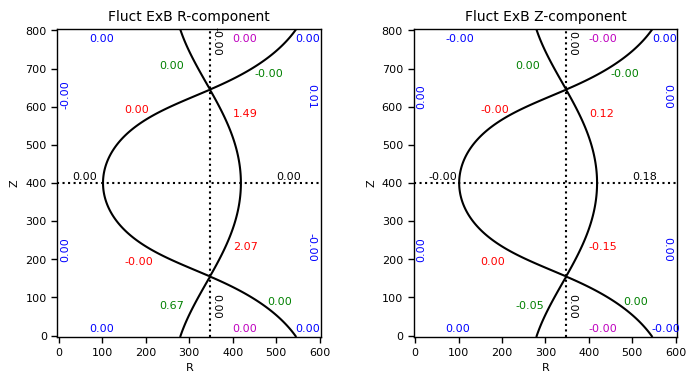

In [218]:
X, Y = np.meshgrid(s.x, s.y)
fig, axes = plt.subplots(ncols=2, figsize=(8,4), dpi=100)

for ax in axes:
    ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='k')
    ax.set_xlabel('R', size=8); 
    ax.set_ylabel('Z', size=8)
    ax.axhline(y=400, c='k', ls=':')
    ax.axvline(x=348, c='k', ls=':')

axes[0].text(450, 680, '%1.2f' %np.sum(Gamma_fluct_ExB_R_RUX_vec), size=8, color='g') 
axes[0].text(230, 700, '%1.2f' %np.sum(Gamma_fluct_ExB_R_LUX_vec), size=8, color='g') 
axes[0].text(480, 80, '%1.2f' %np.sum(Gamma_fluct_ExB_R_RLX_vec), size=8, color='g')  
axes[0].text(230, 70, '%1.2f' %np.sum(Gamma_fluct_ExB_R_LLX_vec), size=8, color='g')  
axes[0].text(400, 575, '%1.2f' %np.sum(Gamma_fluct_ExB_R_UOMP_vec), size=8, color='r')  
axes[0].text(150, 585, '%1.2f' %np.sum(Gamma_fluct_ExB_R_UIMP_vec), size=8, color='r')  
axes[0].text(400, 225, '%1.2f' %np.sum(Gamma_fluct_ExB_R_LOMP_vec), size=8, color='r') 
axes[0].text(150, 185, '%1.2f' %np.sum(Gamma_fluct_ExB_R_LIMP_vec), size=8, color='r') 
axes[0].text(500, 410, '%1.2f' %np.sum(Gamma_fluct_ExB_R_RSOL_vec), size=8, color='k') 
axes[0].text(30, 410, '%1.2f' %np.sum(Gamma_fluct_ExB_R_LSOL_vec), size=8, color='k') 
axes[0].text(70, 770, '%1.2f' %np.sum(Gamma_fluct_ExB_R_TLC_vec), size=8, color='b') 
axes[0].text(545, 770, '%1.2f' %np.sum(Gamma_fluct_ExB_R_TRC_vec), size=8, color='b') 
axes[0].text(70, 10, '%1.2f' %np.sum(Gamma_fluct_ExB_R_BLC_vec), size=8, color='b') 
axes[0].text(545, 10, '%1.2f' %np.sum(Gamma_fluct_ExB_R_BRC_vec), size=8, color='b') 
axes[0].text(3, 600, '%1.2f' %np.sum(Gamma_fluct_ExB_R_LUC_vec), size=8, color='b', rotation=90)
axes[0].text(3, 200, '%1.2f' %np.sum(Gamma_fluct_ExB_R_LLC_vec), size=8, color='b', rotation=90)
axes[0].text(570, 600, '%1.2f' %np.sum(Gamma_fluct_ExB_R_RUC_vec), size=8, color='b', rotation=-90)
axes[0].text(570, 200, '%1.2f' %np.sum(Gamma_fluct_ExB_R_RLC_vec), size=8, color='b', rotation=-90)
axes[0].text(350, 50, '%1.2f' %np.sum(Gamma_fluct_ExB_R_LV_vec), size=8, color='k', rotation=-90)
axes[0].text(400, 10, '%1.2f' %np.sum(Gamma_fluct_ExB_R_BW_vec), size=8, color='m')
axes[0].text(350, 740, '%1.2f' %np.sum(Gamma_fluct_ExB_R_UV_vec), size=8, color='k', rotation=-90)
axes[0].text(400, 770, '%1.2f' %np.sum(Gamma_fluct_ExB_R_TW_vec), size=8, color='m')

##

axes[1].text(450, 680, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_RUX_vec), size=8, color='g') 
axes[1].text(230, 700, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_LUX_vec), size=8, color='g') 
axes[1].text(480, 80, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_RLX_vec), size=8, color='g')  
axes[1].text(230, 70, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_LLX_vec), size=8, color='g')  
axes[1].text(400, 575, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_UOMP_vec), size=8, color='r')  
axes[1].text(150, 585, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_UIMP_vec), size=8, color='r')  
axes[1].text(400, 225, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_LOMP_vec), size=8, color='r') 
axes[1].text(150, 185, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_LIMP_vec), size=8, color='r') 
axes[1].text(500, 410, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_RSOL_vec), size=8, color='k') 
axes[1].text(30, 410, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_LSOL_vec), size=8, color='k') 
axes[1].text(70, 770, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_TLC_vec), size=8, color='b') 
axes[1].text(545, 770, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_TRC_vec), size=8, color='b') 
axes[1].text(70, 10, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_BLC_vec), size=8, color='b') 
axes[1].text(545, 10, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_BRC_vec), size=8, color='b') 
axes[1].text(3, 600, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_LUC_vec), size=8, color='b', rotation=90)
axes[1].text(3, 200, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_LLC_vec), size=8, color='b', rotation=90)
axes[1].text(570, 600, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_RUC_vec), size=8, color='b', rotation=-90)
axes[1].text(570, 200, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_RLC_vec), size=8, color='b', rotation=-90)
axes[1].text(350, 50, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_LV_vec), size=8, color='k', rotation=-90)
axes[1].text(400, 10, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_BW_vec), size=8, color='m')
axes[1].text(350, 740, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_UV_vec), size=8, color='k', rotation=-90)
axes[1].text(400, 770, '%1.2f' %np.sum(Gamma_fluct_ExB_Z_TW_vec), size=8, color='m')

axes[0].set_title('Fluct ExB R-component')
axes[1].set_title('Fluct ExB Z-component')

Text(0.5, 1.0, 'Mean ExB Z-component')

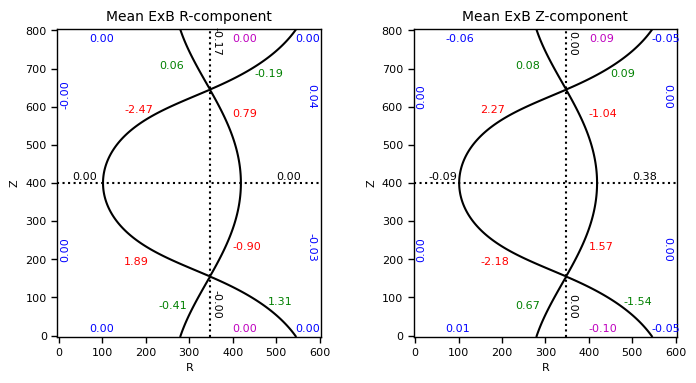

In [219]:
X, Y = np.meshgrid(s.x, s.y)
fig, axes = plt.subplots(ncols=2, figsize=(8,4), dpi=100)

for ax in axes:
    ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='k')
    ax.set_xlabel('R', size=8); 
    ax.set_ylabel('Z', size=8)
    ax.axhline(y=400, c='k', ls=':')
    ax.axvline(x=348, c='k', ls=':')

axes[0].text(450, 680, '%1.2f' %np.sum(Gamma_mean_ExB_R_RUX_vec), size=8, color='g') 
axes[0].text(230, 700, '%1.2f' %np.sum(Gamma_mean_ExB_R_LUX_vec), size=8, color='g') 
axes[0].text(480, 80, '%1.2f' %np.sum(Gamma_mean_ExB_R_RLX_vec), size=8, color='g')  
axes[0].text(230, 70, '%1.2f' %np.sum(Gamma_mean_ExB_R_LLX_vec), size=8, color='g')  
axes[0].text(400, 575, '%1.2f' %np.sum(Gamma_mean_ExB_R_UOMP_vec), size=8, color='r')  
axes[0].text(150, 585, '%1.2f' %np.sum(Gamma_mean_ExB_R_UIMP_vec), size=8, color='r')  
axes[0].text(400, 225, '%1.2f' %np.sum(Gamma_mean_ExB_R_LOMP_vec), size=8, color='r') 
axes[0].text(150, 185, '%1.2f' %np.sum(Gamma_mean_ExB_R_LIMP_vec), size=8, color='r') 
axes[0].text(500, 410, '%1.2f' %np.sum(Gamma_mean_ExB_R_RSOL_vec), size=8, color='k') 
axes[0].text(30, 410, '%1.2f' %np.sum(Gamma_mean_ExB_R_LSOL_vec), size=8, color='k') 
axes[0].text(70, 770, '%1.2f' %np.sum(Gamma_mean_ExB_R_TLC_vec), size=8, color='b') 
axes[0].text(545, 770, '%1.2f' %np.sum(Gamma_mean_ExB_R_TRC_vec), size=8, color='b') 
axes[0].text(70, 10, '%1.2f' %np.sum(Gamma_mean_ExB_R_BLC_vec), size=8, color='b') 
axes[0].text(545, 10, '%1.2f' %np.sum(Gamma_mean_ExB_R_BRC_vec), size=8, color='b') 
axes[0].text(3, 600, '%1.2f' %np.sum(Gamma_mean_ExB_R_LUC_vec), size=8, color='b', rotation=90)
axes[0].text(3, 200, '%1.2f' %np.sum(Gamma_mean_ExB_R_LLC_vec), size=8, color='b', rotation=90)
axes[0].text(570, 600, '%1.2f' %np.sum(Gamma_mean_ExB_R_RUC_vec), size=8, color='b', rotation=-90)
axes[0].text(570, 200, '%1.2f' %np.sum(Gamma_mean_ExB_R_RLC_vec), size=8, color='b', rotation=-90)
axes[0].text(350, 50, '%1.2f' %np.sum(Gamma_mean_ExB_R_LV_vec), size=8, color='k', rotation=-90)
axes[0].text(400, 10, '%1.2f' %np.sum(Gamma_mean_ExB_R_BW_vec), size=8, color='m')
axes[0].text(350, 740, '%1.2f' %np.sum(Gamma_mean_ExB_R_UV_vec), size=8, color='k', rotation=-90)
axes[0].text(400, 770, '%1.2f' %np.sum(Gamma_mean_ExB_R_TW_vec), size=8, color='m')

##

axes[1].text(450, 680, '%1.2f' %np.sum(Gamma_mean_ExB_Z_RUX_vec), size=8, color='g') 
axes[1].text(230, 700, '%1.2f' %np.sum(Gamma_mean_ExB_Z_LUX_vec), size=8, color='g') 
axes[1].text(480, 80, '%1.2f' %np.sum(Gamma_mean_ExB_Z_RLX_vec), size=8, color='g')  
axes[1].text(230, 70, '%1.2f' %np.sum(Gamma_mean_ExB_Z_LLX_vec), size=8, color='g')  
axes[1].text(400, 575, '%1.2f' %np.sum(Gamma_mean_ExB_Z_UOMP_vec), size=8, color='r')  
axes[1].text(150, 585, '%1.2f' %np.sum(Gamma_mean_ExB_Z_UIMP_vec), size=8, color='r')  
axes[1].text(400, 225, '%1.2f' %np.sum(Gamma_mean_ExB_Z_LOMP_vec), size=8, color='r') 
axes[1].text(150, 185, '%1.2f' %np.sum(Gamma_mean_ExB_Z_LIMP_vec), size=8, color='r') 
axes[1].text(500, 410, '%1.2f' %np.sum(Gamma_mean_ExB_Z_RSOL_vec), size=8, color='k') 
axes[1].text(30, 410, '%1.2f' %np.sum(Gamma_mean_ExB_Z_LSOL_vec), size=8, color='k') 
axes[1].text(70, 770, '%1.2f' %np.sum(Gamma_mean_ExB_Z_TLC_vec), size=8, color='b') 
axes[1].text(545, 770, '%1.2f' %np.sum(Gamma_mean_ExB_Z_TRC_vec), size=8, color='b') 
axes[1].text(70, 10, '%1.2f' %np.sum(Gamma_mean_ExB_Z_BLC_vec), size=8, color='b') 
axes[1].text(545, 10, '%1.2f' %np.sum(Gamma_mean_ExB_Z_BRC_vec), size=8, color='b') 
axes[1].text(3, 600, '%1.2f' %np.sum(Gamma_mean_ExB_Z_LUC_vec), size=8, color='b', rotation=90)
axes[1].text(3, 200, '%1.2f' %np.sum(Gamma_mean_ExB_Z_LLC_vec), size=8, color='b', rotation=90)
axes[1].text(570, 600, '%1.2f' %np.sum(Gamma_mean_ExB_Z_RUC_vec), size=8, color='b', rotation=-90)
axes[1].text(570, 200, '%1.2f' %np.sum(Gamma_mean_ExB_Z_RLC_vec), size=8, color='b', rotation=-90)
axes[1].text(350, 50, '%1.2f' %np.sum(Gamma_mean_ExB_Z_LV_vec), size=8, color='k', rotation=-90)
axes[1].text(400, 10, '%1.2f' %np.sum(Gamma_mean_ExB_Z_BW_vec), size=8, color='m')
axes[1].text(350, 740, '%1.2f' %np.sum(Gamma_mean_ExB_Z_UV_vec), size=8, color='k', rotation=-90)
axes[1].text(400, 770, '%1.2f' %np.sum(Gamma_mean_ExB_Z_TW_vec), size=8, color='m')

axes[0].set_title('Mean ExB R-component')
axes[1].set_title('Mean ExB Z-component')

Text(0.5, 1.0, 'Diamag Z-component')

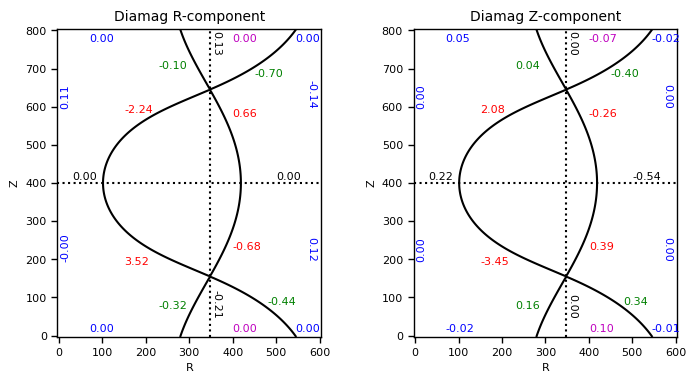

In [220]:
X, Y = np.meshgrid(s.x, s.y)
fig, axes = plt.subplots(ncols=2, figsize=(8,4), dpi=100)

for ax in axes:
    ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='k')
    ax.set_xlabel('R', size=8); 
    ax.set_ylabel('Z', size=8)
    ax.axhline(y=400, c='k', ls=':')
    ax.axvline(x=348, c='k', ls=':')

axes[0].text(450, 680, '%1.2f' %np.sum(Gamma_diamag_R_RUX_vec), size=8, color='g') 
axes[0].text(230, 700, '%1.2f' %np.sum(Gamma_diamag_R_LUX_vec), size=8, color='g') 
axes[0].text(480, 80, '%1.2f' %np.sum(Gamma_diamag_R_RLX_vec), size=8, color='g')  
axes[0].text(230, 70, '%1.2f' %np.sum(Gamma_diamag_R_LLX_vec), size=8, color='g')  
axes[0].text(400, 575, '%1.2f' %np.sum(Gamma_diamag_R_UOMP_vec), size=8, color='r')  
axes[0].text(150, 585, '%1.2f' %np.sum(Gamma_diamag_R_UIMP_vec), size=8, color='r')  
axes[0].text(400, 225, '%1.2f' %np.sum(Gamma_diamag_R_LOMP_vec), size=8, color='r') 
axes[0].text(150, 185, '%1.2f' %np.sum(Gamma_diamag_R_LIMP_vec), size=8, color='r') 
axes[0].text(500, 410, '%1.2f' %np.sum(Gamma_diamag_R_RSOL_vec), size=8, color='k') 
axes[0].text(30, 410, '%1.2f' %np.sum(Gamma_diamag_R_LSOL_vec), size=8, color='k') 
axes[0].text(70, 770, '%1.2f' %np.sum(Gamma_diamag_R_TLC_vec), size=8, color='b') 
axes[0].text(545, 770, '%1.2f' %np.sum(Gamma_diamag_R_TRC_vec), size=8, color='b') 
axes[0].text(70, 10, '%1.2f' %np.sum(Gamma_diamag_R_BLC_vec), size=8, color='b') 
axes[0].text(545, 10, '%1.2f' %np.sum(Gamma_diamag_R_BRC_vec), size=8, color='b') 
axes[0].text(3, 600, '%1.2f' %np.sum(Gamma_diamag_R_LUC_vec), size=8, color='b', rotation=90)
axes[0].text(3, 200, '%1.2f' %np.sum(Gamma_diamag_R_LLC_vec), size=8, color='b', rotation=90)
axes[0].text(570, 600, '%1.2f' %np.sum(Gamma_diamag_R_RUC_vec), size=8, color='b', rotation=-90)
axes[0].text(570, 200, '%1.2f' %np.sum(Gamma_diamag_R_RLC_vec), size=8, color='b', rotation=-90)
axes[0].text(350, 50, '%1.2f' %np.sum(Gamma_diamag_R_LV_vec), size=8, color='k', rotation=-90)
axes[0].text(400, 10, '%1.2f' %np.sum(Gamma_diamag_R_BW_vec), size=8, color='m')
axes[0].text(350, 740, '%1.2f' %np.sum(Gamma_diamag_R_UV_vec), size=8, color='k', rotation=-90)
axes[0].text(400, 770, '%1.2f' %np.sum(Gamma_diamag_R_TW_vec), size=8, color='m')

##

axes[1].text(450, 680, '%1.2f' %np.sum(Gamma_diamag_Z_RUX_vec), size=8, color='g') 
axes[1].text(230, 700, '%1.2f' %np.sum(Gamma_diamag_Z_LUX_vec), size=8, color='g') 
axes[1].text(480, 80, '%1.2f' %np.sum(Gamma_diamag_Z_RLX_vec), size=8, color='g')  
axes[1].text(230, 70, '%1.2f' %np.sum(Gamma_diamag_Z_LLX_vec), size=8, color='g')  
axes[1].text(400, 575, '%1.2f' %np.sum(Gamma_diamag_Z_UOMP_vec), size=8, color='r')  
axes[1].text(150, 585, '%1.2f' %np.sum(Gamma_diamag_Z_UIMP_vec), size=8, color='r')  
axes[1].text(400, 225, '%1.2f' %np.sum(Gamma_diamag_Z_LOMP_vec), size=8, color='r') 
axes[1].text(150, 185, '%1.2f' %np.sum(Gamma_diamag_Z_LIMP_vec), size=8, color='r') 
axes[1].text(500, 410, '%1.2f' %np.sum(Gamma_diamag_Z_RSOL_vec), size=8, color='k') 
axes[1].text(30, 410, '%1.2f' %np.sum(Gamma_diamag_Z_LSOL_vec), size=8, color='k') 
axes[1].text(70, 770, '%1.2f' %np.sum(Gamma_diamag_Z_TLC_vec), size=8, color='b') 
axes[1].text(545, 770, '%1.2f' %np.sum(Gamma_diamag_Z_TRC_vec), size=8, color='b') 
axes[1].text(70, 10, '%1.2f' %np.sum(Gamma_diamag_Z_BLC_vec), size=8, color='b') 
axes[1].text(545, 10, '%1.2f' %np.sum(Gamma_diamag_Z_BRC_vec), size=8, color='b') 
axes[1].text(3, 600, '%1.2f' %np.sum(Gamma_diamag_Z_LUC_vec), size=8, color='b', rotation=90)
axes[1].text(3, 200, '%1.2f' %np.sum(Gamma_diamag_Z_LLC_vec), size=8, color='b', rotation=90)
axes[1].text(570, 600, '%1.2f' %np.sum(Gamma_diamag_Z_RUC_vec), size=8, color='b', rotation=-90)
axes[1].text(570, 200, '%1.2f' %np.sum(Gamma_diamag_Z_RLC_vec), size=8, color='b', rotation=-90)
axes[1].text(350, 50, '%1.2f' %np.sum(Gamma_diamag_Z_LV_vec), size=8, color='k', rotation=-90)
axes[1].text(400, 10, '%1.2f' %np.sum(Gamma_diamag_Z_BW_vec), size=8, color='m')
axes[1].text(350, 740, '%1.2f' %np.sum(Gamma_diamag_Z_UV_vec), size=8, color='k', rotation=-90)
axes[1].text(400, 770, '%1.2f' %np.sum(Gamma_diamag_Z_TW_vec), size=8, color='m')

axes[0].set_title('Diamag R-component')
axes[1].set_title('Diamag Z-component')

Text(0.5, 1.0, 'Parallel Z-component')

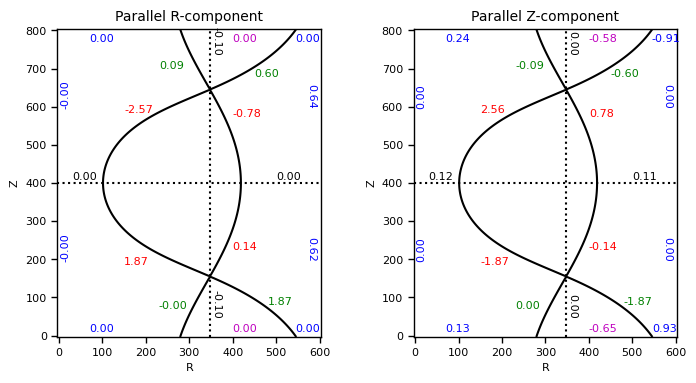

In [221]:
X, Y = np.meshgrid(s.x, s.y)
fig, axes = plt.subplots(ncols=2, figsize=(8,4), dpi=100)

for ax in axes:
    ax.contour(X, Y, s.Psi, levels=[s.Psi[s.iyxpt, s.ixxpt]],colors='k')
    ax.set_xlabel('R', size=8); 
    ax.set_ylabel('Z', size=8)
    ax.axhline(y=400, c='k', ls=':')
    ax.axvline(x=348, c='k', ls=':')

axes[0].text(450, 680, '%1.2f' %np.sum(Gamma_par_R_RUX_vec), size=8, color='g') 
axes[0].text(230, 700, '%1.2f' %np.sum(Gamma_par_R_LUX_vec), size=8, color='g') 
axes[0].text(480, 80, '%1.2f' %np.sum(Gamma_par_R_RLX_vec), size=8, color='g')  
axes[0].text(230, 70, '%1.2f' %np.sum(Gamma_par_R_LLX_vec), size=8, color='g')  
axes[0].text(400, 575, '%1.2f' %np.sum(Gamma_par_R_UOMP_vec), size=8, color='r')  
axes[0].text(150, 585, '%1.2f' %np.sum(Gamma_par_R_UIMP_vec), size=8, color='r')  
axes[0].text(400, 225, '%1.2f' %np.sum(Gamma_par_R_LOMP_vec), size=8, color='r') 
axes[0].text(150, 185, '%1.2f' %np.sum(Gamma_par_R_LIMP_vec), size=8, color='r') 
axes[0].text(500, 410, '%1.2f' %np.sum(Gamma_par_R_RSOL_vec), size=8, color='k') 
axes[0].text(30, 410, '%1.2f' %np.sum(Gamma_par_R_LSOL_vec), size=8, color='k') 
axes[0].text(70, 770, '%1.2f' %np.sum(Gamma_par_R_TLC_vec), size=8, color='b') 
axes[0].text(545, 770, '%1.2f' %np.sum(Gamma_par_R_TRC_vec), size=8, color='b') 
axes[0].text(70, 10, '%1.2f' %np.sum(Gamma_par_R_BLC_vec), size=8, color='b') 
axes[0].text(545, 10, '%1.2f' %np.sum(Gamma_par_R_BRC_vec), size=8, color='b') 
axes[0].text(3, 600, '%1.2f' %np.sum(Gamma_par_R_LUC_vec), size=8, color='b', rotation=90)
axes[0].text(3, 200, '%1.2f' %np.sum(Gamma_par_R_LLC_vec), size=8, color='b', rotation=90)
axes[0].text(570, 600, '%1.2f' %np.sum(Gamma_par_R_RUC_vec), size=8, color='b', rotation=-90)
axes[0].text(570, 200, '%1.2f' %np.sum(Gamma_par_R_RLC_vec), size=8, color='b', rotation=-90)
axes[0].text(350, 50, '%1.2f' %np.sum(Gamma_par_R_LV_vec), size=8, color='k', rotation=-90)
axes[0].text(400, 10, '%1.2f' %np.sum(Gamma_par_R_BW_vec), size=8, color='m')
axes[0].text(350, 740, '%1.2f' %np.sum(Gamma_par_R_UV_vec), size=8, color='k', rotation=-90)
axes[0].text(400, 770, '%1.2f' %np.sum(Gamma_par_R_TW_vec), size=8, color='m')

##

axes[1].text(450, 680, '%1.2f' %np.sum(Gamma_par_Z_RUX_vec), size=8, color='g') 
axes[1].text(230, 700, '%1.2f' %np.sum(Gamma_par_Z_LUX_vec), size=8, color='g') 
axes[1].text(480, 80, '%1.2f' %np.sum(Gamma_par_Z_RLX_vec), size=8, color='g')  
axes[1].text(230, 70, '%1.2f' %np.sum(Gamma_par_Z_LLX_vec), size=8, color='g')  
axes[1].text(400, 575, '%1.2f' %np.sum(Gamma_par_Z_UOMP_vec), size=8, color='r')  
axes[1].text(150, 585, '%1.2f' %np.sum(Gamma_par_Z_UIMP_vec), size=8, color='r')  
axes[1].text(400, 225, '%1.2f' %np.sum(Gamma_par_Z_LOMP_vec), size=8, color='r') 
axes[1].text(150, 185, '%1.2f' %np.sum(Gamma_par_Z_LIMP_vec), size=8, color='r') 
axes[1].text(500, 410, '%1.2f' %np.sum(Gamma_par_Z_RSOL_vec), size=8, color='k') 
axes[1].text(30, 410, '%1.2f' %np.sum(Gamma_par_Z_LSOL_vec), size=8, color='k') 
axes[1].text(70, 770, '%1.2f' %np.sum(Gamma_par_Z_TLC_vec), size=8, color='b') 
axes[1].text(545, 770, '%1.2f' %np.sum(Gamma_par_Z_TRC_vec), size=8, color='b') 
axes[1].text(70, 10, '%1.2f' %np.sum(Gamma_par_Z_BLC_vec), size=8, color='b') 
axes[1].text(545, 10, '%1.2f' %np.sum(Gamma_par_Z_BRC_vec), size=8, color='b') 
axes[1].text(3, 600, '%1.2f' %np.sum(Gamma_par_Z_LUC_vec), size=8, color='b', rotation=90)
axes[1].text(3, 200, '%1.2f' %np.sum(Gamma_par_Z_LLC_vec), size=8, color='b', rotation=90)
axes[1].text(570, 600, '%1.2f' %np.sum(Gamma_par_Z_RUC_vec), size=8, color='b', rotation=-90)
axes[1].text(570, 200, '%1.2f' %np.sum(Gamma_par_Z_RLC_vec), size=8, color='b', rotation=-90)
axes[1].text(350, 50, '%1.2f' %np.sum(Gamma_par_Z_LV_vec), size=8, color='k', rotation=-90)
axes[1].text(400, 10, '%1.2f' %np.sum(Gamma_par_Z_BW_vec), size=8, color='m')
axes[1].text(350, 740, '%1.2f' %np.sum(Gamma_par_Z_UV_vec), size=8, color='k', rotation=-90)
axes[1].text(400, 770, '%1.2f' %np.sum(Gamma_par_Z_TW_vec), size=8, color='m')

axes[0].set_title('Parallel R-component')
axes[1].set_title('Parallel Z-component')

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b> Comparison of each contribution </b></span><br>
</div>

In [222]:
# Flux leaving the separatrix 
Flux_sep_fluct_ExB_OMP = []; Flux_sep_fluct_ExB_IMP=[]
Flux_sep_mean_ExB_OMP = []; Flux_sep_mean_ExB_IMP = []
Flux_sep_diamag_OMP = []; Flux_sep_diamag_IMP = []
Flux_sep_par_OMP = []; Flux_sep_par_IMP = []

# UOMP, UIMP, LOMP, LIMP
Flux_sep_fluct_ExB_OMP.append(Gamma_fluct_ExB_R_UOMP_sum + Gamma_fluct_ExB_Z_UOMP_sum 
                             + Gamma_fluct_ExB_R_LOMP_sum + Gamma_fluct_ExB_Z_LOMP_sum)
Flux_sep_fluct_ExB_IMP.append(Gamma_fluct_ExB_R_UIMP_sum + Gamma_fluct_ExB_Z_UIMP_sum 
                             + Gamma_fluct_ExB_R_LIMP_sum + Gamma_fluct_ExB_Z_LIMP_sum)

Flux_sep_mean_ExB_OMP.append(Gamma_mean_ExB_R_UOMP_sum + Gamma_fluct_ExB_Z_UOMP_sum
                            + Gamma_mean_ExB_R_LOMP_sum + Gamma_fluct_ExB_Z_LOMP_sum)

Flux_sep_mean_ExB_IMP.append(Gamma_mean_ExB_R_UIMP_sum + Gamma_fluct_ExB_Z_UIMP_sum
                            + Gamma_mean_ExB_R_LIMP_sum + Gamma_fluct_ExB_Z_LIMP_sum)

Flux_sep_diamag_OMP.append(Gamma_diamag_R_UOMP_sum + Gamma_diamag_Z_UOMP_sum
                            + Gamma_diamag_R_LOMP_sum + Gamma_diamag_Z_LOMP_sum)

Flux_sep_diamag_IMP.append(Gamma_diamag_R_UIMP_sum + Gamma_diamag_Z_UIMP_sum
                            + Gamma_diamag_R_LIMP_sum + Gamma_diamag_Z_LIMP_sum)

Flux_sep_par_OMP.append(Gamma_par_R_UOMP_sum + Gamma_par_Z_UOMP_sum
                            + Gamma_par_R_LOMP_sum + Gamma_par_Z_LOMP_sum)

Flux_sep_par_IMP.append(Gamma_par_R_UIMP_sum + Gamma_par_Z_UIMP_sum
                            + Gamma_par_R_LIMP_sum + Gamma_par_Z_LIMP_sum)

# Flux OMP total
Flux_OMP_total = np.sum(Flux_sep_fluct_ExB_OMP + Flux_sep_mean_ExB_OMP + Flux_sep_diamag_OMP + Flux_sep_par_OMP)
Flux_IMP_total = np.sum(Flux_sep_fluct_ExB_IMP + Flux_sep_mean_ExB_IMP + Flux_sep_diamag_IMP + Flux_sep_par_IMP)

# Vertical flux
Flux_RSOL_fluct_ExB = []; Flux_LSOL_fluct_ExB = []
Flux_RSOL_mean_ExB = []; Flux_LSOL_mean_ExB = []
Flux_RSOL_diamag = []; Flux_LSOL_diamag = []
Flux_RSOL_par = []; Flux_LSOL_par = []

Flux_RSOL_fluct_ExB.append(Gamma_fluct_ExB_Z_RSOL_sum)
Flux_LSOL_fluct_ExB.append(Gamma_fluct_ExB_Z_LSOL_sum)

Flux_RSOL_mean_ExB.append(Gamma_mean_ExB_Z_RSOL_sum)
Flux_LSOL_mean_ExB.append(Gamma_mean_ExB_Z_LSOL_sum)

Flux_RSOL_diamag.append(Gamma_diamag_Z_RSOL_sum)
Flux_LSOL_diamag.append(Gamma_diamag_Z_LSOL_sum)

Flux_RSOL_par.append(Gamma_par_Z_RSOL_sum)
Flux_LSOL_par.append(Gamma_par_Z_LSOL_sum)

Flux_RSOL_total = np.sum(Flux_RSOL_fluct_ExB + Flux_RSOL_mean_ExB + Flux_RSOL_diamag + Flux_RSOL_par)
Flux_LSOL_total = np.sum(Flux_LSOL_fluct_ExB + Flux_LSOL_mean_ExB + Flux_LSOL_diamag + Flux_LSOL_par)

print(round(Flux_OMP_total, 3), round(Flux_IMP_total,3), round(Flux_RSOL_total, 3), round(Flux_LSOL_total,3))

3.499 -0.674 0.13 0.253


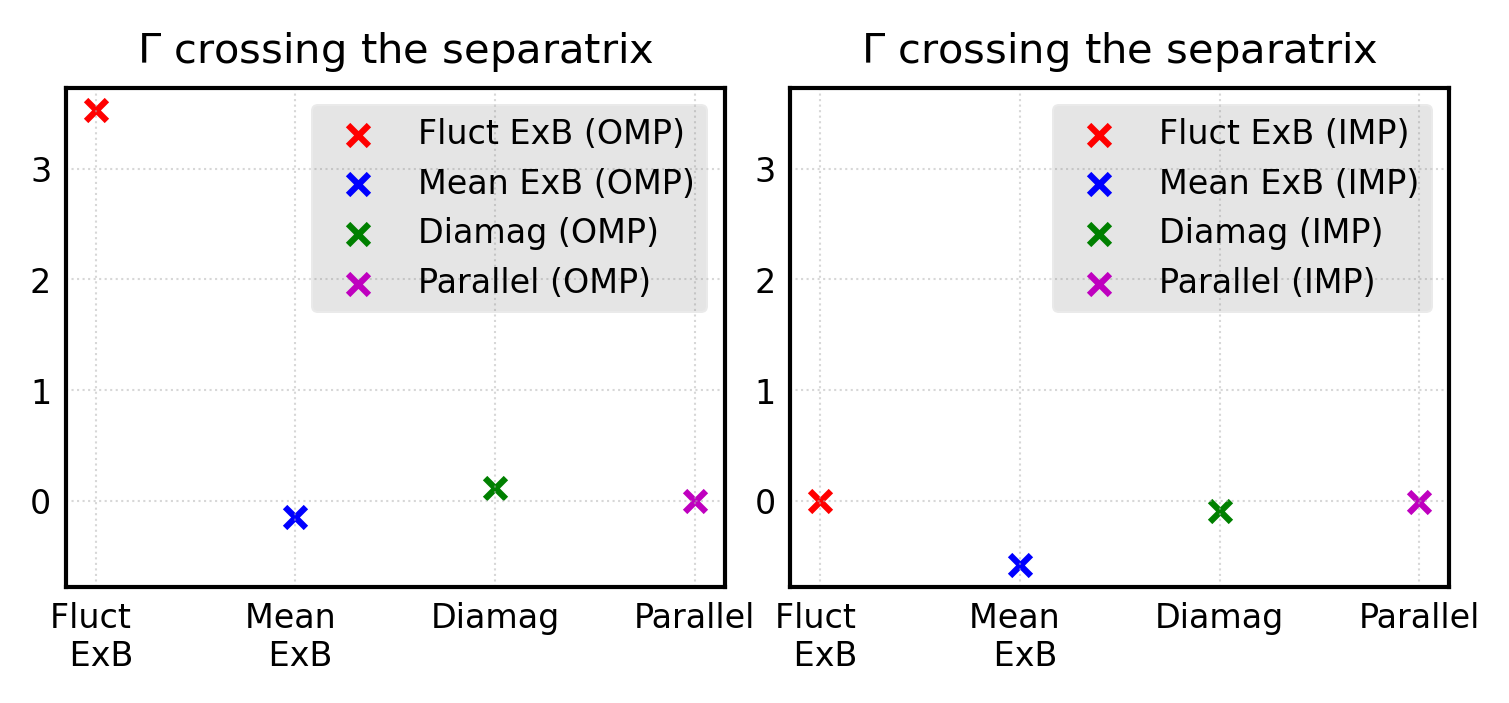

In [225]:
fig_width = 3.5  # IEEE column width in inches
fig_height = fig_width / 1.618  # Golden ratio height for a single subplot

plt.rcParams.update({
    'font.family': 'sans-serif', #helvetica, sans-serif
    #'text.usetex': True,  # Use this only if LaTeX is installed and configured
})

#fig, axes = plt.subplots(ncols=2, figsize=(2*fig_width, 3.5), sharey=True)
fig, axes = plt.subplots(ncols=2, figsize=(1.7*fig_width, fig_height), sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)



tick_positions = [0, 1, 2, 3]  # These are the positions where you want the ticks to be
tick_labels = ['Fluct \n ExB', 'Mean \n ExB', 'Diamag', 'Parallel']

axes[0].scatter(x_axis[0], Flux_sep_fluct_ExB_OMP, marker='x', label=r'Fluct ExB (OMP)', c='r')
axes[0].scatter(x_axis[1], Flux_sep_mean_ExB_OMP, marker='x',  label=r'Mean ExB (OMP)', c='b')

axes[0].scatter(x_axis[2], Flux_sep_diamag_OMP, marker='x', label=r'Diamag (OMP)', c='g')
axes[0].scatter(x_axis[3], Flux_sep_par_OMP, marker='x',  label=r'Parallel (OMP)', c='m')

axes[1].scatter(x_axis[0], Flux_sep_fluct_ExB_IMP, marker='x', label=r'Fluct ExB (IMP)', c='r')
axes[1].scatter(x_axis[1], Flux_sep_mean_ExB_IMP, marker='x',  label=r'Mean ExB (IMP)', c='b')

axes[1].scatter(x_axis[2], Flux_sep_diamag_IMP, marker='x', label=r'Diamag (IMP)', c='g')
axes[1].scatter(x_axis[3], Flux_sep_par_IMP, marker='x',  label=r'Parallel (IMP)', c='m')


# Set the tick positions and labels
axes[0].set_xticks(tick_positions)
axes[0].set_xticklabels(tick_labels)
axes[1].set_xticks(tick_positions)
axes[1].set_xticklabels(tick_labels)

for ax in axes:
    ax.grid(True, which='major', lw=0.5)
    ax.tick_params(axis='both', which='both', length=0, labelbottom=True, labelleft=True)
    #ax.grid(True, which='major', alpha=0.8, linestyle=':', linewidth=0.5)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    

axes[0].set_title(r'$\Gamma$ crossing the separatrix')
axes[1].set_title(r'$\Gamma$ crossing the separatrix')

axes[0].legend(bbox_to_anchor=(1., 1), loc='upper right', facecolor='grey', framealpha=0.2)
axes[1].legend(bbox_to_anchor=(1., 1), loc='upper right', facecolor='grey', framealpha=0.2)
#plt.tight_layout()


Text(0.5, 1.0, 'Far SOL (HFS)')

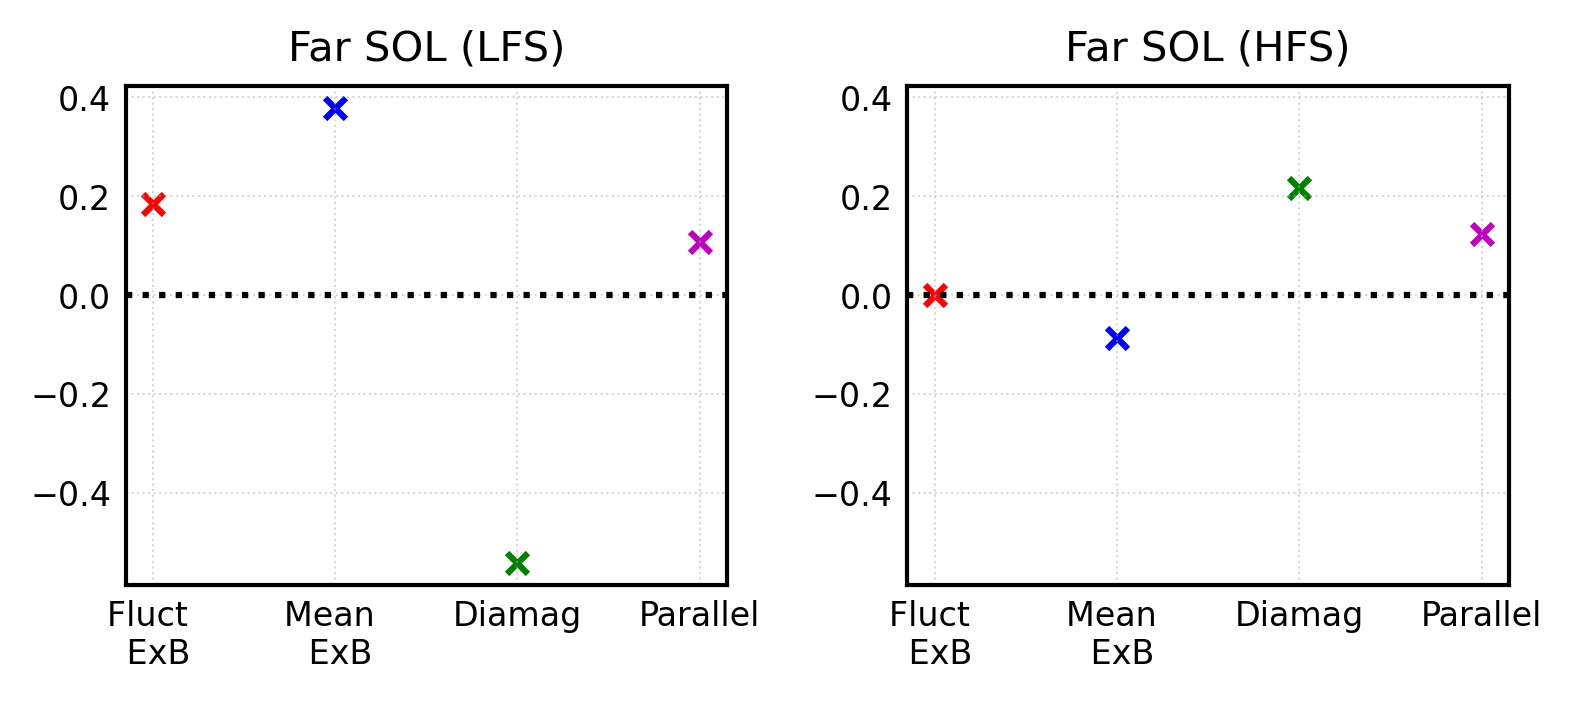

In [224]:
fig_width = 3.5  # IEEE column width in inches
fig_height = fig_width / 1.618  # Golden ratio height for a single subplot

plt.rcParams.update({
    'font.family': 'sans-serif', #helvetica, sans-serif
    #'text.usetex': True,  # Use this only if LaTeX is installed and configured
})

#fig, axes = plt.subplots(ncols=2, figsize=(2*fig_width, 3.5), sharey=True)
fig, axes = plt.subplots(ncols=2, figsize=(1.7*fig_width, fig_height), sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)



tick_positions = [0, 1, 2, 3]  # These are the positions where you want the ticks to be
tick_labels = ['Fluct \n ExB', 'Mean \n ExB', 'Diamag', 'Parallel']

axes[0].scatter(x_axis[0], Flux_RSOL_fluct_ExB, marker='x', label=r'Fluct ExB (OMP)', c='r')
axes[0].scatter(x_axis[1], Flux_RSOL_mean_ExB, marker='x',  label=r'Mean ExB (OMP)', c='b')
#axes[0].scatter(x_axis[1], -0.1, marker='x',  label=r'Mean ExB (OMP)', c='b')

axes[0].scatter(x_axis[2], Flux_RSOL_diamag, marker='x', label=r'Diamag (OMP)', c='g')
axes[0].scatter(x_axis[3], Flux_RSOL_par, marker='x',  label=r'Parallel (OMP)', c='m')

axes[1].scatter(x_axis[0], Flux_LSOL_fluct_ExB, marker='x', label=r'Fluct ExB (OMP)', c='r')
axes[1].scatter(x_axis[1], Flux_LSOL_mean_ExB, marker='x',  label=r'Mean ExB (OMP)', c='b')

axes[1].scatter(x_axis[2], Flux_LSOL_diamag, marker='x', label=r'Diamag (OMP)', c='g')
axes[1].scatter(x_axis[3], Flux_LSOL_par, marker='x',  label=r'Parallel (OMP)', c='m')


# Set the tick positions and labels
axes[0].set_xticks(tick_positions)
axes[0].set_xticklabels(tick_labels)
axes[1].set_xticks(tick_positions)
axes[1].set_xticklabels(tick_labels)

for ax in axes:
    ax.grid(True, which='major', lw=0.5)
    ax.tick_params(axis='both', which='both', length=0, labelbottom=True, labelleft=True)
    #ax.grid(True, which='major', alpha=0.8, linestyle=':', linewidth=0.5)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.axhline(y=0, c='k', ls=':')
    

axes[0].set_title(r'Far SOL (LFS)')
axes[1].set_title(r'Far SOL (HFS)')

#axes[0].legend(bbox_to_anchor=(1., 1), loc='upper right', facecolor='grey', framealpha=0.2)
#axes[1].legend(bbox_to_anchor=(1., 1), loc='upper right', facecolor='grey', framealpha=0.2)
#plt.tight_layout()
